# **Telco Customer Churn Prediction**

### **📌 Business Case**
Telecommunications companies lose millions annually due to customer churn. Anticipating this behavior allows the company to act preventively, offering personalized benefits or solutions to keep the customer in the base.

### **🎯 Objective**
Predict whether a customer is likely to cancel service based on their contractual, demographic and usage data.

In [1]:
import pandas as pd 
from config.paths_config import *
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier

In [2]:
data= pd.read_csv(RAW_DATA)

## **🔍 1. Data Exploration**
In this section, we will perform an initial exploration of the dataset with the goal of understanding its structure, quality, and key characteristics. This analysis is essential to identify potential consistency issues, incorrect data types, missing values, and relevant patterns that may influence predictive modeling.

### **1.1. Overview do Dataset**

In [3]:
data.shape

(7043, 21)

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Adjusting the data type of the Total Charges column to numeric:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Adjust the SeniorCitizen column to categorical:
data['SeniorCitizen'] = data['SeniorCitizen'].astype(str)

### **1.2. Check for null/missing values**

In [7]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
# replacing zero values ​​with the mean:
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\2387369211.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


### **1.3. Check unique values ​​per column**

In [9]:
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")

customerID: 7043 unique values
gender: 2 unique values
SeniorCitizen: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
tenure: 73 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
MonthlyCharges: 1585 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


Based on the count of unique values ​​per column, we can draw the following conclusions:

**1. Identification of categorical and numerical variables:**

- Most variables with up to 4 unique values ​​are categorical (e.g. `gender`, `Partner`, `InternetService`, `Churn`), which can be encoded with **LabelEncoder** or **OneHotEncoder**.

- The columns `MonthlyCharges`, `TotalCharges`, and `tenure` have many unique values ​​and are continuous numeric variables, suitable for statistical analysis and normalization.

**2. `customerID` column:**

- It has 7043 unique values ​​(equal to the total number of records), being a unique identifier. This column is not useful for modeling and can be discarded.

**3. Columns with 3 unique values:**

- Variables like `MultipleLines`, `OnlineSecurity`, `TechSupport`, etc., are likely to contain categories like "Yes", "No", and "No internet service" — these categories require careful preprocessing, as "No internet service" may or may not be grouped with "No" depending on the context of the model.

**4. Target variable (Churn):**

- It contains only 2 categories (Yes, No), which confirms that we are dealing with a binary classification problem.

## **📊 2. Univariate Analysis**

### **2.1. Numeric Variables**

In [10]:
def analyze_numeric_variables(df, coluna_numerica):
    plt.figure(figsize=(14, 5))

   # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[coluna_numerica], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of {coluna_numerica}')
    plt.xlabel(coluna_numerica)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[coluna_numerica], color='lightgreen')
    plt.title(f'Boxplot de {coluna_numerica}')
    plt.xlabel(coluna_numerica)

    plt.tight_layout()
    plt.show()

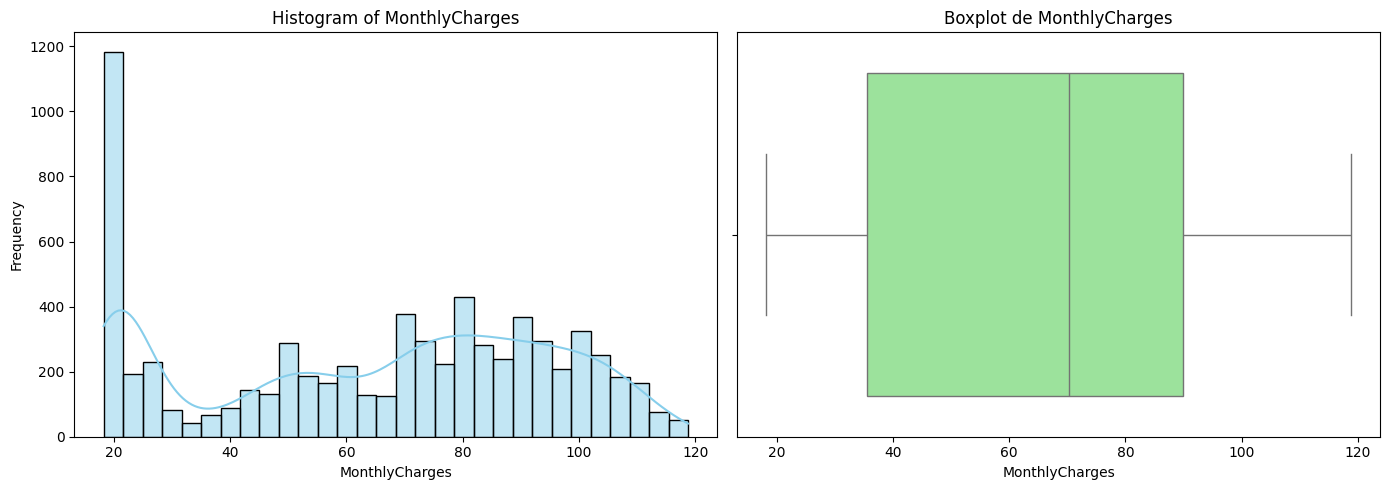

In [11]:
analyze_numeric_variables(data, coluna_numerica='MonthlyCharges')

**Histogram of MonthlyCharges:**

- Distribution skewed to the right (i.e., positive distribution): The largest concentration of customers pay lower amounts, around 20 to 30 monetary units, with a tail extending to higher amounts.

- Visible peaks indicate that there are distinct groups of customers with monthly plans in specific price ranges, which may reflect different service packages offered.

**Boxplot of MonthlyCharges:**

- The median (line in the middle of the box) is between 70 and 75, indicating that half of the customers pay up to this amount.

- The box (which represents the interquartile range, i.e., from the 1st to the 3rd quartile) is quite wide, showing high dispersion in the amounts charged, indicating the possibility of a wide range of services provided.

- There are few or no visible outliers, which indicates that the extreme values ​​are not too far outside the norm.

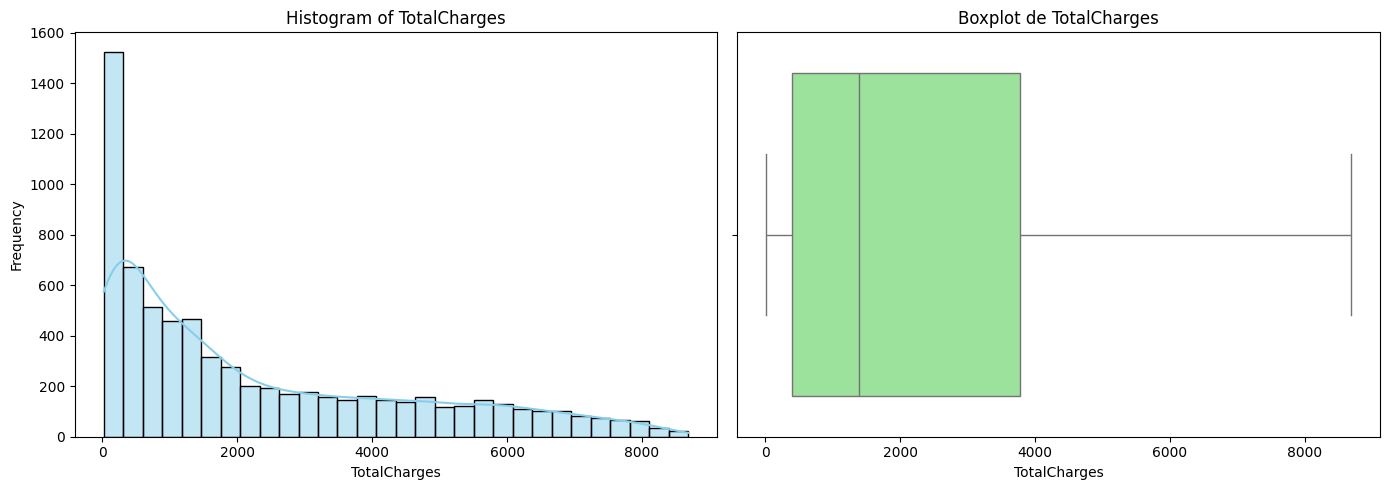

In [14]:
analyze_numeric_variables(data, coluna_numerica='TotalCharges')

**Histogram of Total Charges**:
- Highly right-skewed (positively skewed) distribution:

- Most customers have low Total Charges (total amount paid to date), below 2,000 monetary units. This may indicate that more customers are selling cheaper services.

- The long tail shows that few customers have ever paid amounts above 5,000.

**Boxplot of Total Charges**:
- Most of the data is concentrated in the interquartile range (IQR) up to about 4,000.

- There are outliers with higher amounts — customers who have been with us for a long time or on expensive plans.

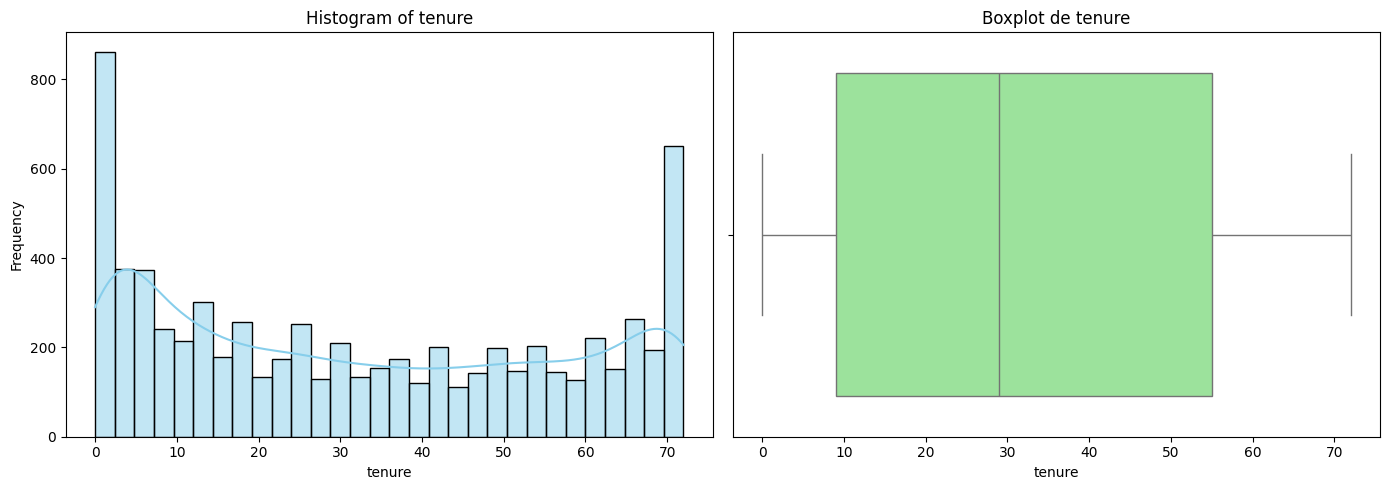

In [15]:
analyze_numeric_variables(data, coluna_numerica='tenure')

The `tenure` variable would be an indicator that represents the **length of time the customer has been with the company** in this case in months.

- If **tenure = 1**, the customer joined in the last month.

- If **tenure = 72**, the customer has been with the company for 6 years.

**Tenure Histogram**:

- High concentration of customers with very little time at the company (mainly in the first 3 months).
- There is also a peak at 72 months, indicating very loyal customers.
- Between these extremes, the distribution is well spread out, but with less frequency in the middle (customers with 20 to 50 months are less common).

**Boxplot**:
- The median is around 30 months.

- The distribution is relatively balanced, but with a slight asymmetry to the left, since there are more customers with little time.

### **2.2. Categorical Variables**

In [16]:
def analyze_frequency(df, column, top_n=None, figsize=(10, 5), palette="viridis"):
    """
    Displays the frequency of unique values ​​in a column and plots a bar chart with the values ​​at the top.

    Parameters:
    - df: DataFrame
    - column: name of the column to analyze
    - top_n: number of most frequent categories to display (None = all)
    - figsize: size of the figure
    - palette: seaborn's color palette  
    """
    # Check if column exists
    if column not in df.columns:
        print(f"Columns '{column}' not found in DataFrame.")
        return
    
    # Frequency of values
    freq = df[column].value_counts().sort_values(ascending=False)

   # Show table
    print(f"\nFrequency of unique values ​​in the column '{column}':\n")
    display(freq.head(top_n) if top_n else freq)

    # Data for the chart
    x = freq.head(top_n).index if top_n else freq.index
    y = freq.head(top_n).values if top_n else freq.values

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=x, y=y, palette=palette)
    plt.title(f"Frequency of unique values ​​in '{column}'")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

    # Add the values ​​at the top of the bars
    for i, value in enumerate(y):
        ax.text(i, value + max(y)*0.01, str(value), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


Frequency of unique values ​​in the column 'gender':



gender
Male      3555
Female    3488
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


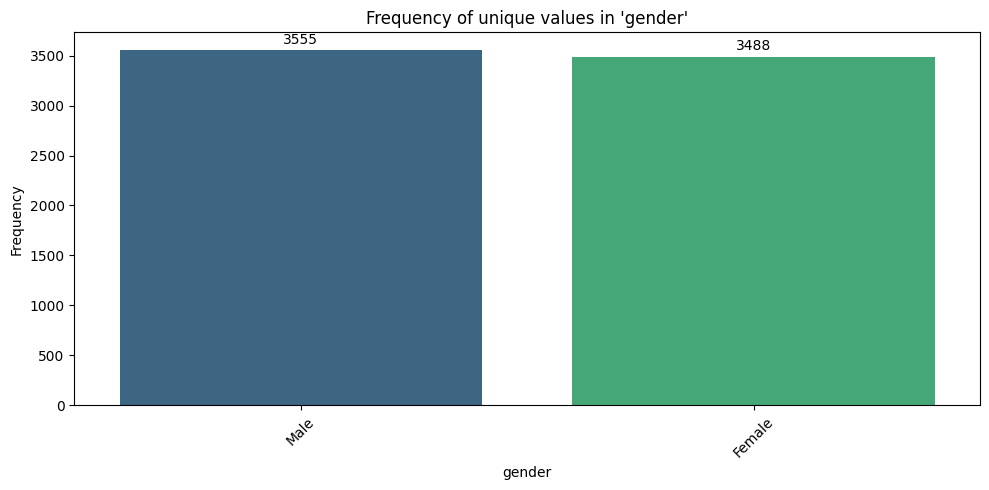

In [17]:
# Analyze frequency of 'Contract' column
analyze_frequency(data, 'gender')

- The gender distribution is quite balanced in the dataset.

- There are 3,555 male customers (50.5%) and 3,488 female customers (49.5%).

- This indicates that there is no significant gender bias in the dataset, which is important to avoid distortions during model training.


Frequency of unique values ​​in the column 'SeniorCitizen':



SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


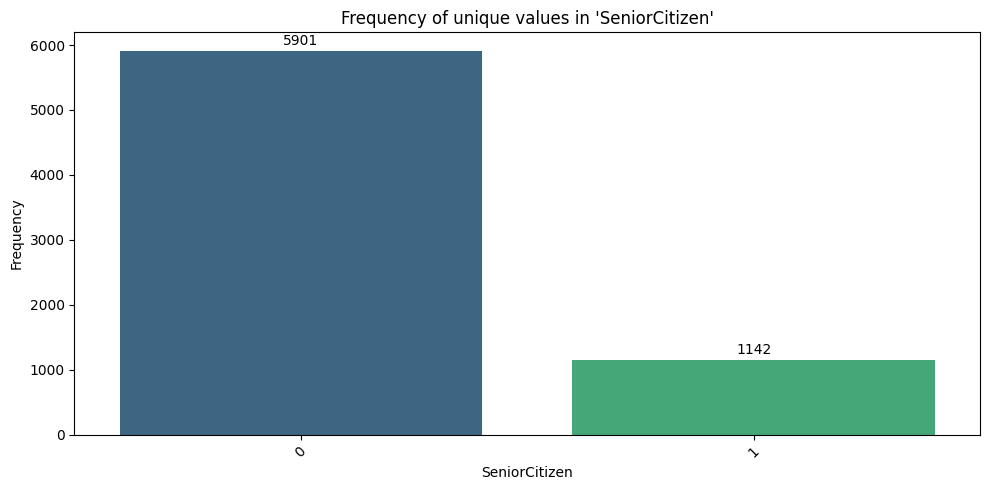

In [18]:
analyze_frequency(data, 'SeniorCitizen')

- There is a strong imbalance in the distribution of this variable.

- Approximately 84% of customers (5,901) are not seniors (`SeniorCitizen = 0`), while only 16% (1,142) are considered seniors (`SeniorCitizen = 1`).

- This imbalance may impact the model's ability to learn patterns relevant to the smaller group (seniors), especially if the variable is related to churn.

- Therefore, it is important to check whether senior customers have different churn rates, and consider balancing techniques (such as oversampling or stratified sampling) if necessary.


Frequency of unique values ​​in the column 'Partner':



Partner
No     3641
Yes    3402
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


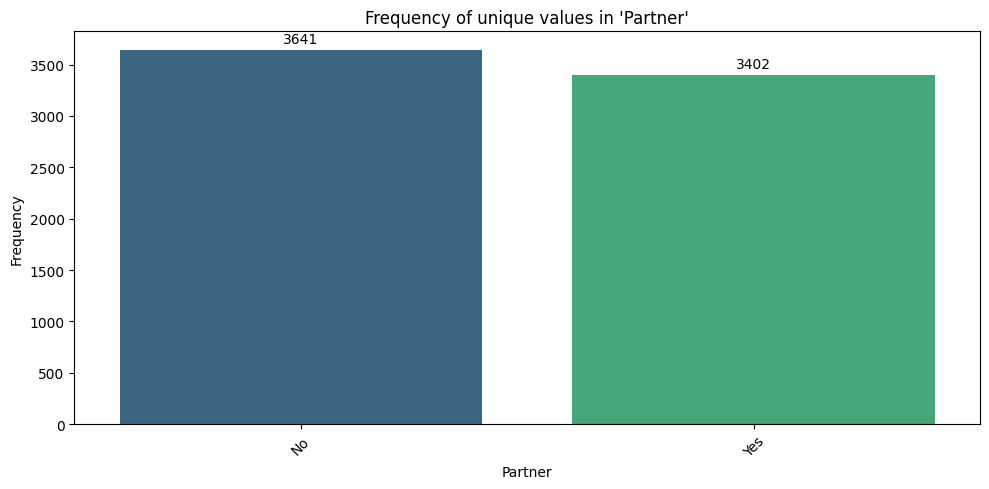

In [19]:
analyze_frequency(data, 'Partner')

- The distribution between customers with and without a partner is relatively balanced, but with a slight predominance of customers without a partner.

- 51.7% of customers (3,641) do not have a partner (`Partner = No`), while 48.3% (3,402) do (`Partner = Yes`).

- This slight imbalance should not negatively impact the model, but it is interesting to analyze whether the presence of a partner influences the retention or cancellation of the service (Churn).


Frequency of unique values ​​in the column 'Dependents':



Dependents
No     4933
Yes    2110
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


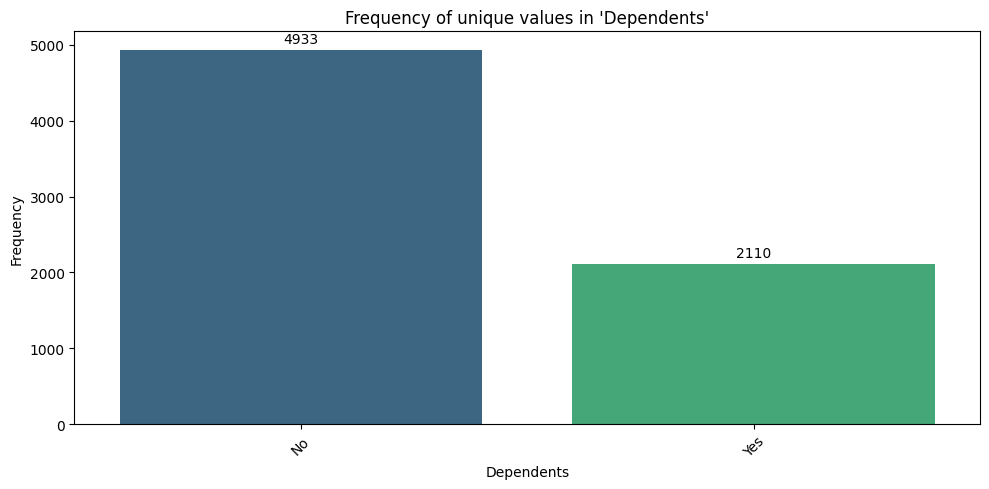

In [20]:
analyze_frequency(data, 'Dependents')

- The distribution reveals a strong imbalance:

- 70.1% of customers (4,933) do not have dependents (`Dependents = No`),

- while only 29.9% (2,110) have dependents (`Dependents = Yes`).

- This may indicate that the customer base is mostly composed of people without children or financial dependents — possibly singles or couples without children. It is important to check whether the presence of dependents is associated with cancellation behavior (Churn). Customers with dependents may demonstrate greater stability and commitment to contracted services, which may influence the cancellation rate.


Frequency of unique values ​​in the column 'PhoneService':



PhoneService
Yes    6361
No      682
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


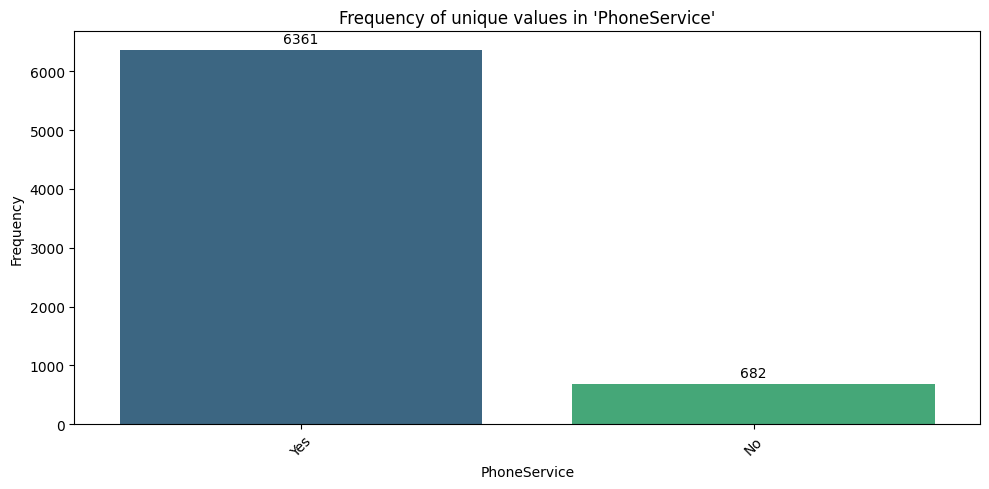

In [21]:
analyze_frequency(data, 'PhoneService')

- The distribution shows a strong imbalance between customers who have telephone service and those who do not:

- 90.3% of customers (6,361) have `PhoneService = Yes`;

- Only 9.7% (682) do not have this service.

- This pattern may indicate that telephone service is **almost a standard in the packages contracted** by the customer base, functioning as a base service to which other products can be added (such as internet, streaming or technical support).

- From the point of view of churn, it may be interesting to investigate:

- Whether customers without `PhoneService` are more or less likely to cancel;

- Whether telephone service contributes to greater loyalty when included in packages.


Frequency of unique values ​​in the column 'MultipleLines':



MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


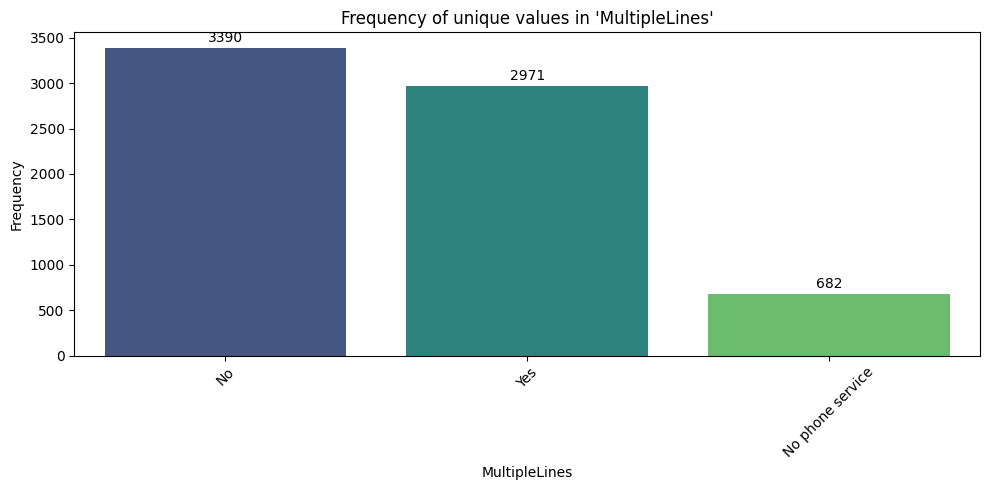

In [22]:
analyze_frequency(data, 'MultipleLines')

- Most customers have a single line (3,390) versus multiple lines (2,971). In addition, there is a significant group that does not have phone service (682).

- Customers with multiple lines are usually larger homes or businesses and, in general, may have a higher revenue value.

- Customers with a single line may be more sensitive to price or service — potentially more prone to churn.

- The graph above may indicate that the company tends to serve more customers who request only one line as a service.

- It is worth deepening the analysis of the churn rate by category to validate whether the feature strongly impacts the risk of cancellation.


Frequency of unique values ​​in the column 'InternetService':



InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


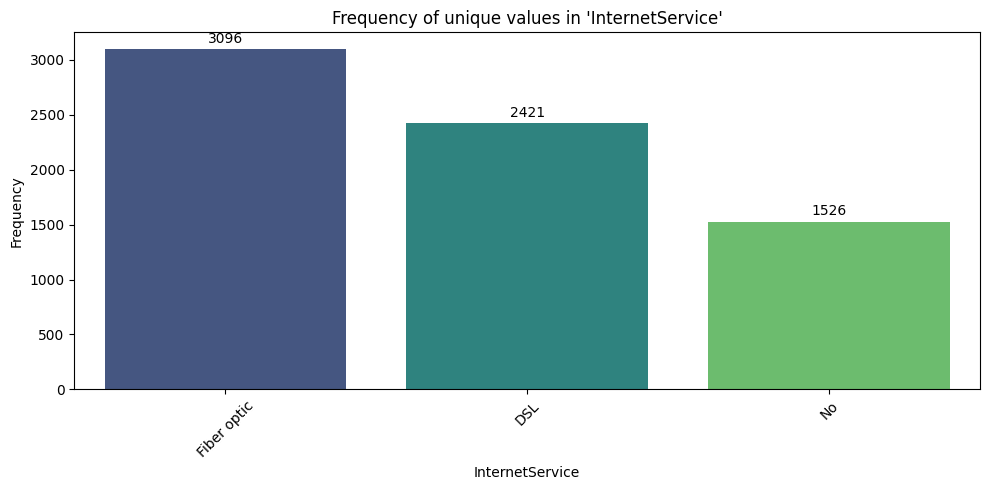

In [23]:
analyze_frequency(data, 'InternetService')

- Most customers use fiber optic (3096), followed by DSL (2421) and then customers who do not have internet service (1526).

- In this context, it is worth analyzing whether customers with fiber optics have higher or lower churn rates, because although it is the most modern service, the cost can also be higher when compared to the competition.

- Assess whether customers with DSL are more likely to cancel due to technical problems or dissatisfaction with speed.

- For customers without internet, retention strategies can focus on other services.

- For building the model:

- The `InternetService` variable can be highly relevant, as it indicates the type of service contracted, which has a direct impact on satisfaction and, consequently, on churn.

- In this case, it is worth calculating the churn rate for each category to understand the behavior of the groups.

- Check whether there are interactions of this variable with others, such as monthly price, contract, additional services.


Frequency of unique values ​​in the column 'OnlineSecurity':



OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


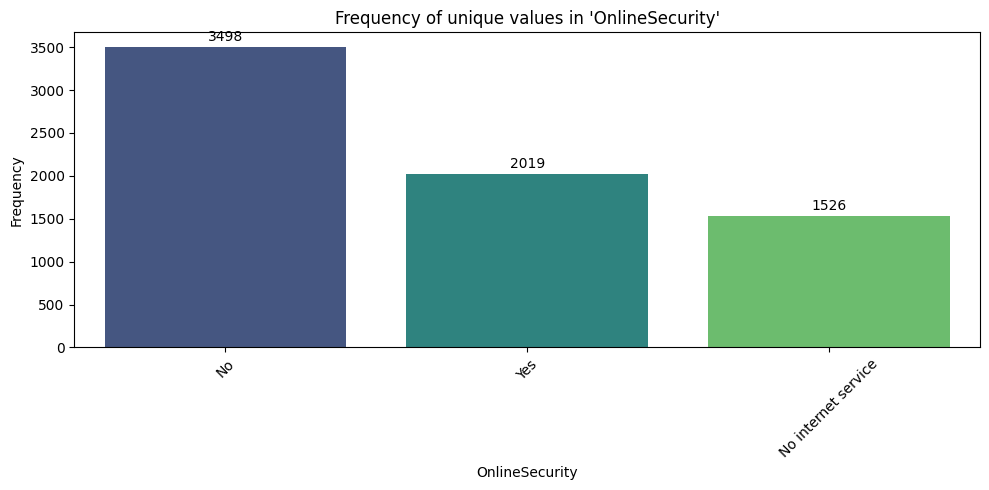

In [24]:
analyze_frequency(data, 'OnlineSecurity')

- The high number of customers who do not use the online security service, even among those who have internet access, may indicate:

- The customer does not perceive the value of this service.

- Problems in the company's communication or service offering.

- Price sensitivity, especially if the service is charged separately.

- This may be an opportunity for upselling campaigns focused on digital security, especially in a scenario where cyber threats are increasingly common.

- It is also important to check whether the absence of this service is correlated with churn, that is:

- Check whether customers without online security are more likely to cancel. If so, offering this service as a benefit in retention strategies may be effective.


Frequency of unique values ​​in the column 'OnlineBackup':



OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


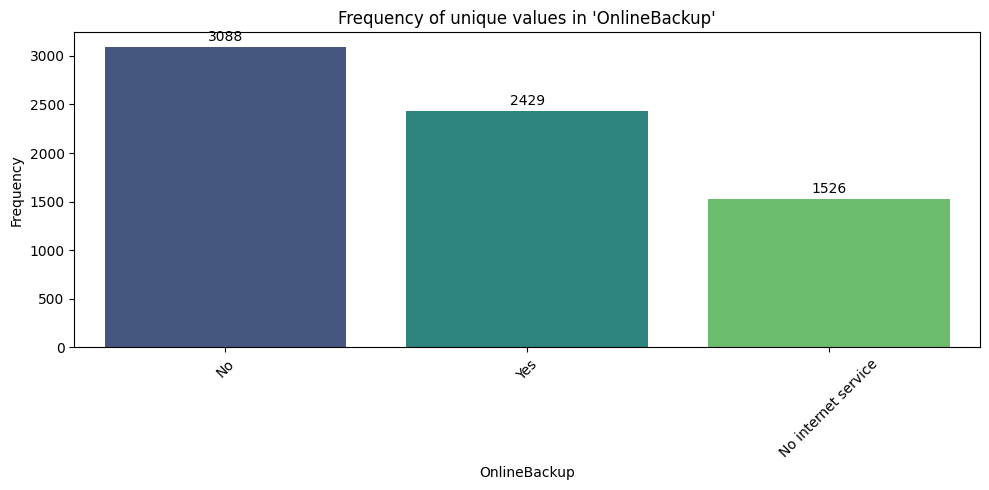

In [25]:
analyze_frequency(data, 'OnlineBackup')

- Analysis of the `OnlineBackup` variable shows that a significant portion of customers with internet access have not contracted the online backup service, while a smaller portion uses the service regularly. Another 1,526 customers do not have internet access and are therefore ineligible for the service.

- From a strategic point of view, this variable can indicate the level of customer engagement with the digital services offered by the company. If customers who use the service are less likely to churn, this functionality can be used as a loyalty element. Therefore, it is worth including this variable in the predictive modeling and investigating its relationship with service cancellation.


Frequency of unique values ​​in the column 'DeviceProtection':



DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


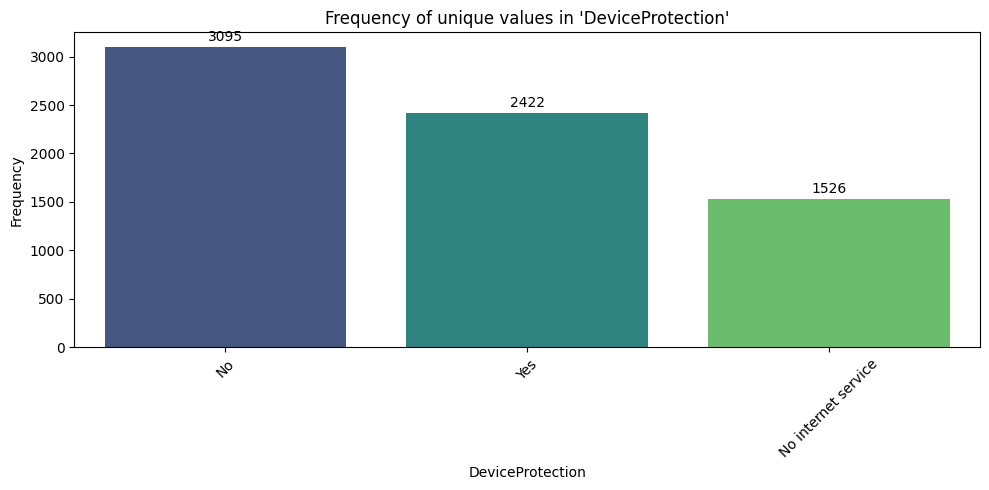

In [26]:
analyze_frequency(data, 'DeviceProtection')

- The `DeviceProtection` variable shows that most customers with internet access chose not to purchase the device protection service, while a considerable portion made use of this benefit. Another 1,526 customers did not have internet access and were therefore not eligible for the service.

- This pattern may indicate a low perception of value or low attractiveness of the service, which represents an opportunity for commercial and loyalty-building actions. If the use of the service is associated with lower churn rates, the `DeviceProtection` offer could be used as a preventive retention strategy. Therefore, this variable should be maintained in predictive modeling, as it may represent an important indicator of customer behavior.


Frequency of unique values ​​in the column 'TechSupport':



TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


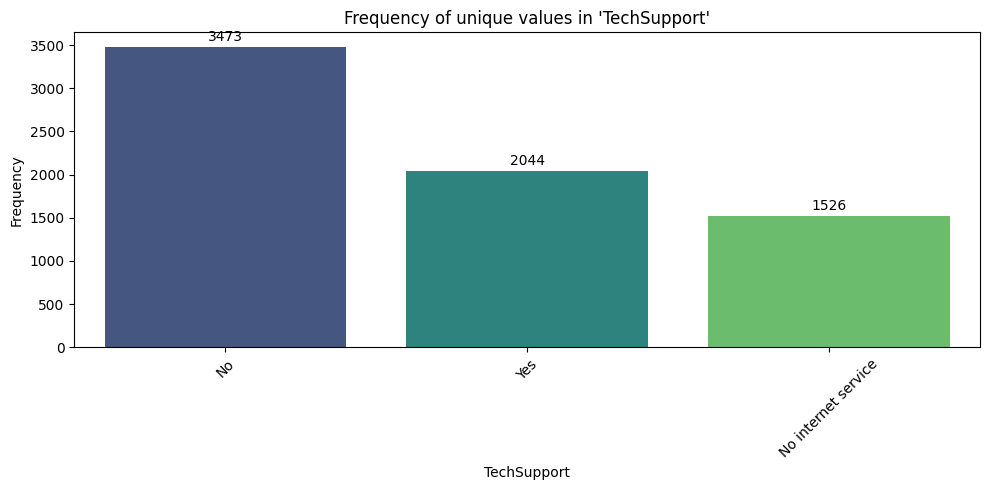

In [27]:
analyze_frequency(data, 'TechSupport')

- The `TechSupport` variable shows that most customers with internet access have not contracted the technical support service. 2,044 customers use it regularly, while 1,526 customers do not have internet service and are therefore not eligible for support.

- From a strategic point of view, the technical support service can be an important differentiator in the customer experience, especially at critical moments. If a lower churn rate is observed among customers who use this service, it can be positioned as a retention tool or included in personalized offers. Therefore, it is recommended that the variable be considered in predictive modeling as a possible indicator of engagement and loyalty.


Frequency of unique values ​​in the column 'StreamingTV':



StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


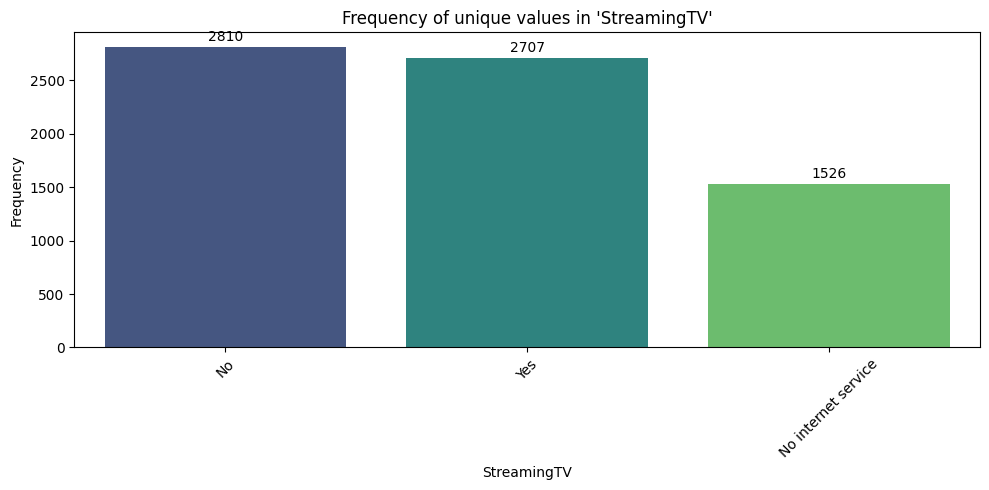

In [28]:
analyze_frequency(data, 'StreamingTV')

- The `StreamingTV` variable presents a balanced distribution between customers who have subscribed to the service (2,707) and those who have chosen not to subscribe (2,810), among those with internet access. Another 1,526 customers do not have internet service and therefore do not have access to the streaming TV service.

- This balanced distribution may indicate that the service is well accepted in the market, but there is still room for growth. If subscribing to the service is associated with a lower propensity for churn, its offer can be positioned as a strategic benefit for customer retention. Therefore, it is recommended to include `StreamingTV` in the predictive modeling as a potentially relevant variable to identify the level of customer engagement.


Frequency of unique values ​​in the column 'StreamingMovies':



StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


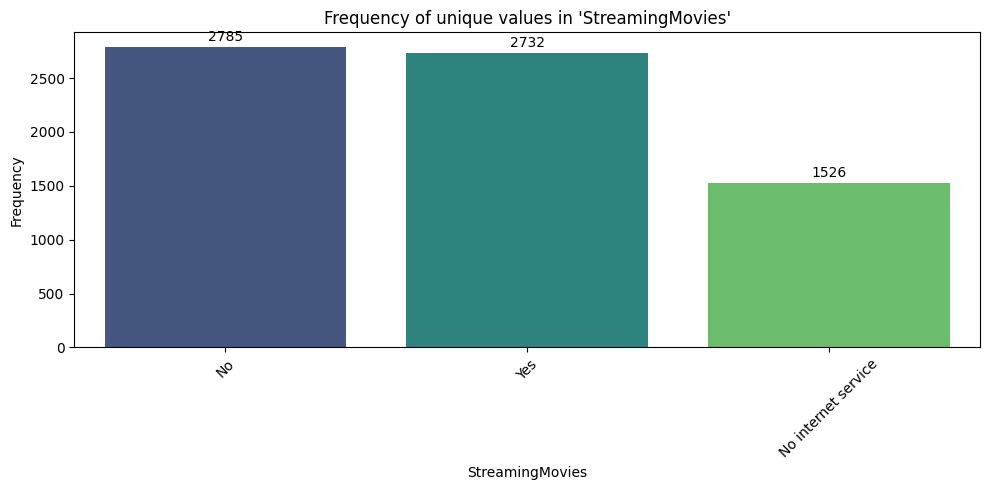

In [29]:
analyze_frequency(data, 'StreamingMovies')

- The `StreamingMovies` variable shows an almost balanced division among customers with internet: 2,732 have subscribed to the service and 2,785 have not. Another 1,526 customers do not have internet access, making them ineligible for the service.

- This parity suggests that the movie service is well accepted among users, but there is still potential for growth. If it is confirmed that customers who use this type of service are less likely to churn, it can be explored as a loyalty tool, including through combined packages.

- Therefore, `StreamingMovies` should be considered a relevant variable for predictive modeling, since it can reflect the level of engagement and propensity for customer retention.


Frequency of unique values ​​in the column 'Contract':



Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


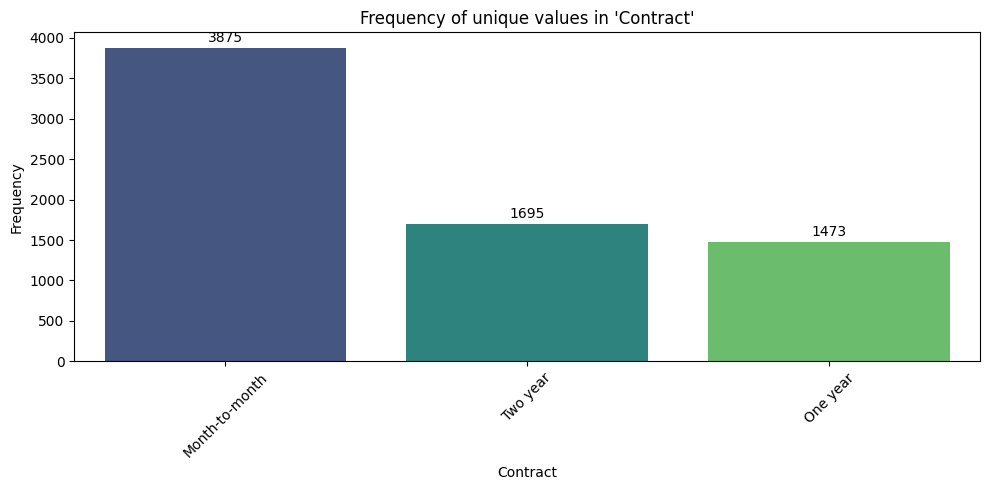

In [30]:
analyze_frequency(data, 'Contract')

- The `Contract` variable reveals that more than 60% of customers are on the `Month-to-month` plan, that is, without a long-term contractual relationship. This indicates a highly volatile base, with a higher risk of cancellation. The `One-year` and `Two-year` contracts represent a smaller share, but tend to be more stable and committed.

- Given that monthly plans generally have higher churn rates, this variable can be critical for both predictive modeling and retention actions. Initiatives that encourage migration to longer contracts can help stabilize the base and reduce revenue losses. Therefore, `Contract` should be considered one of the most relevant variables for predicting churn, and can also be used as a basis for targeted loyalty campaigns.


Frequency of unique values ​​in the column 'PaperlessBilling':



PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


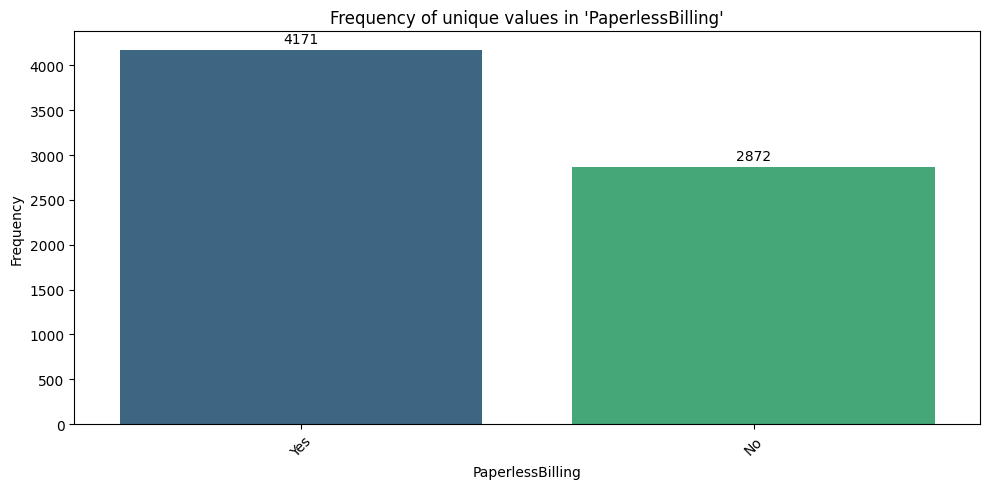

In [31]:
analyze_frequency(data, 'PaperlessBilling')

- Most customers (around 59%) opted for digital billing (`PaperlessBilling = Yes`), which may indicate greater familiarity with online channels and a preference for convenience.

- However, in many cases, this profile is also associated with a higher risk of churn, especially when combined with monthly contracts (given the ease of canceling the service). Customers with `PaperlessBilling = No` may represent a more conservative but more stable base. Therefore, this variable should be considered in predictive modeling, as it can help capture different levels of customer engagement and behavior regarding the company's services.


Frequency of unique values ​​in the column 'PaymentMethod':



PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


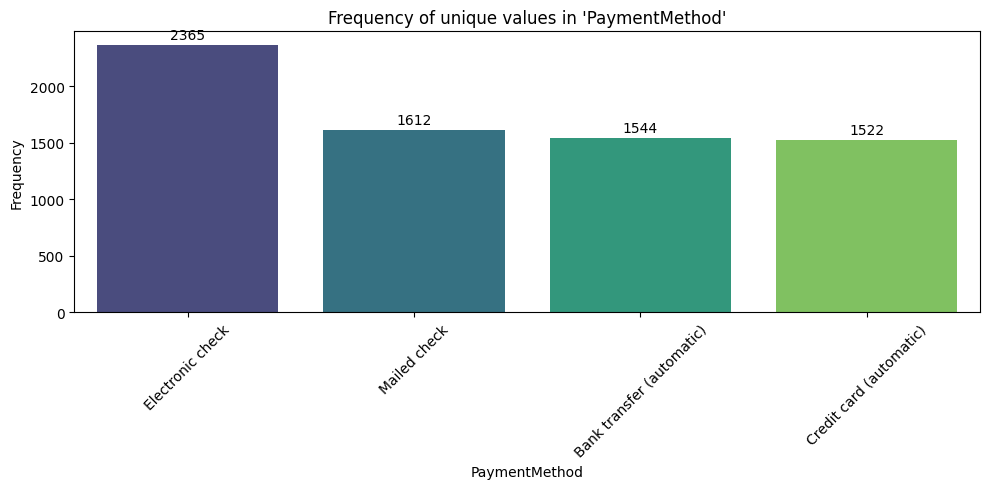

In [32]:
analyze_frequency(data, 'PaymentMethod')

- The `PaymentMethod` variable reveals important differences in customer profiles. The most common method is `Electronic check`, followed by `Mailed check`, while automatic methods (`Bank transfer` and `Credit card`) are less used.

- Automatic methods are often associated with **more stable customers and less likely to churn**, as they involve less recurring effort. On the other hand, customers who use `Electronic check` tend to have a **higher risk of cancellation**, possibly because they are more susceptible to payment difficulties or lower engagement.

- Therefore, this variable may have a strong predictive value and may contribute to strategies that encourage migration to automatic methods, as a way to increase retention.


Frequency of unique values ​​in the column 'Churn':



Churn
No     5174
Yes    1869
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_536\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


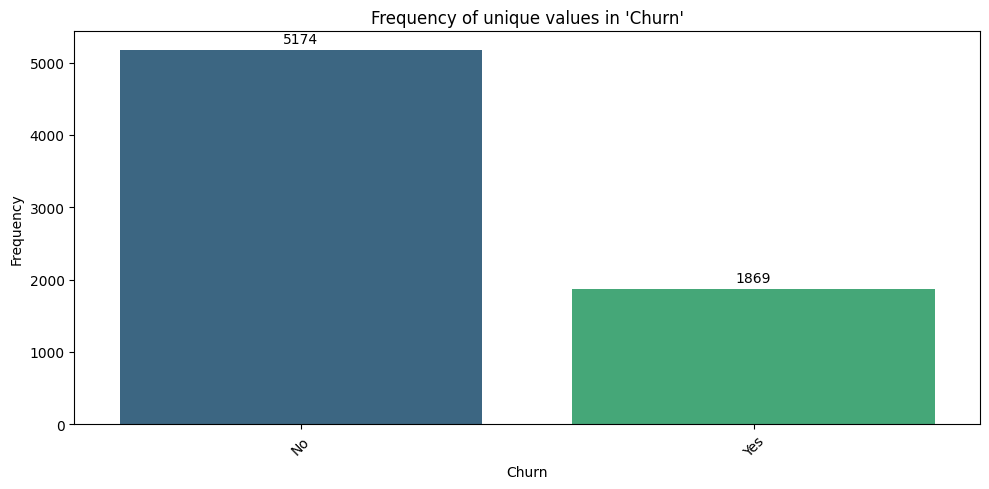

In [33]:
analyze_frequency(data, 'Churn')

- The `Churn` variable, which represents service cancellation, shows that **approximately 26.5% of customers canceled the service**. This is a significant rate that highlights the importance of preventive actions and retention strategies. From a modeling perspective, this variable presents a certain **class imbalance**, which requires special care in the choice of modeling techniques and evaluation metrics, to ensure that the model can correctly identify customers at risk, even if they are a minority.

## **🔄 3. Bivariate Analysis**

### **3.1. Categorical variables vs Churn**

In [ ]:
def plot_categorical_churn_with_counts(df, categorical_vars, target='Churn', positive_class='Yes', ncols=2, figsize_per_plot=(8,5)):
    nplots = len(categorical_vars)
    nrows = (nplots + ncols - 1) // ncols
    
    plt.figure(figsize=(figsize_per_plot[0]*ncols, figsize_per_plot[1]*nrows))
    
    for i, cat_var in enumerate(categorical_vars, 1):
        plt.subplot(nrows, ncols, i)
        
        # Group to count total and calculate churn rate
        grouped = df.groupby(cat_var)
        counts = grouped.size()
        churn_rate = grouped[target].apply(lambda x: (x == positive_class).mean())
        
        # Create dataframe to plot
        plot_df = pd.DataFrame({'count': counts, 'churn_rate': churn_rate})
        plot_df = plot_df.sort_values('churn_rate', ascending=False).reset_index()
        
        # Plot bars for counting
        ax1 = plt.gca()
        sns.barplot(x=cat_var, y='count', data=plot_df, color='lightgray', ax=ax1)
        ax1.set_ylabel('Número de Clientes', color='gray')
        ax1.set_xlabel(cat_var)
        ax1.tick_params(axis='x', rotation=45)
        
        # Add numbers on top of the bars
        for idx, row in plot_df.iterrows():
            ax1.text(idx, row['count'] + max(plot_df['count'])*0.01, f"{row['count']}", 
                     ha='center', va='bottom', color='black', fontsize=9)
        
        # Create secondary axis for churn rate
        ax2 = ax1.twinx()
        sns.pointplot(x=cat_var, y='churn_rate', data=plot_df, color='red', ax=ax2)
        ax2.set_ylabel('Taxa de Churn (%)', color='red')
        ax2.set_ylim(0, 1)
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
        
        # Adicionar números ao lado dos pontos da linha
        for idx, row in plot_df.iterrows():
            ax2.text(idx, row['churn_rate'] + 0.03, f"{row['churn_rate']*100:.1f}%", 
                     ha='center', va='bottom', color='red', fontsize=9)
        
        plt.title(f'{cat_var} - Número de Clientes e Taxa de Churn')
    
    plt.tight_layout()
    plt.show()


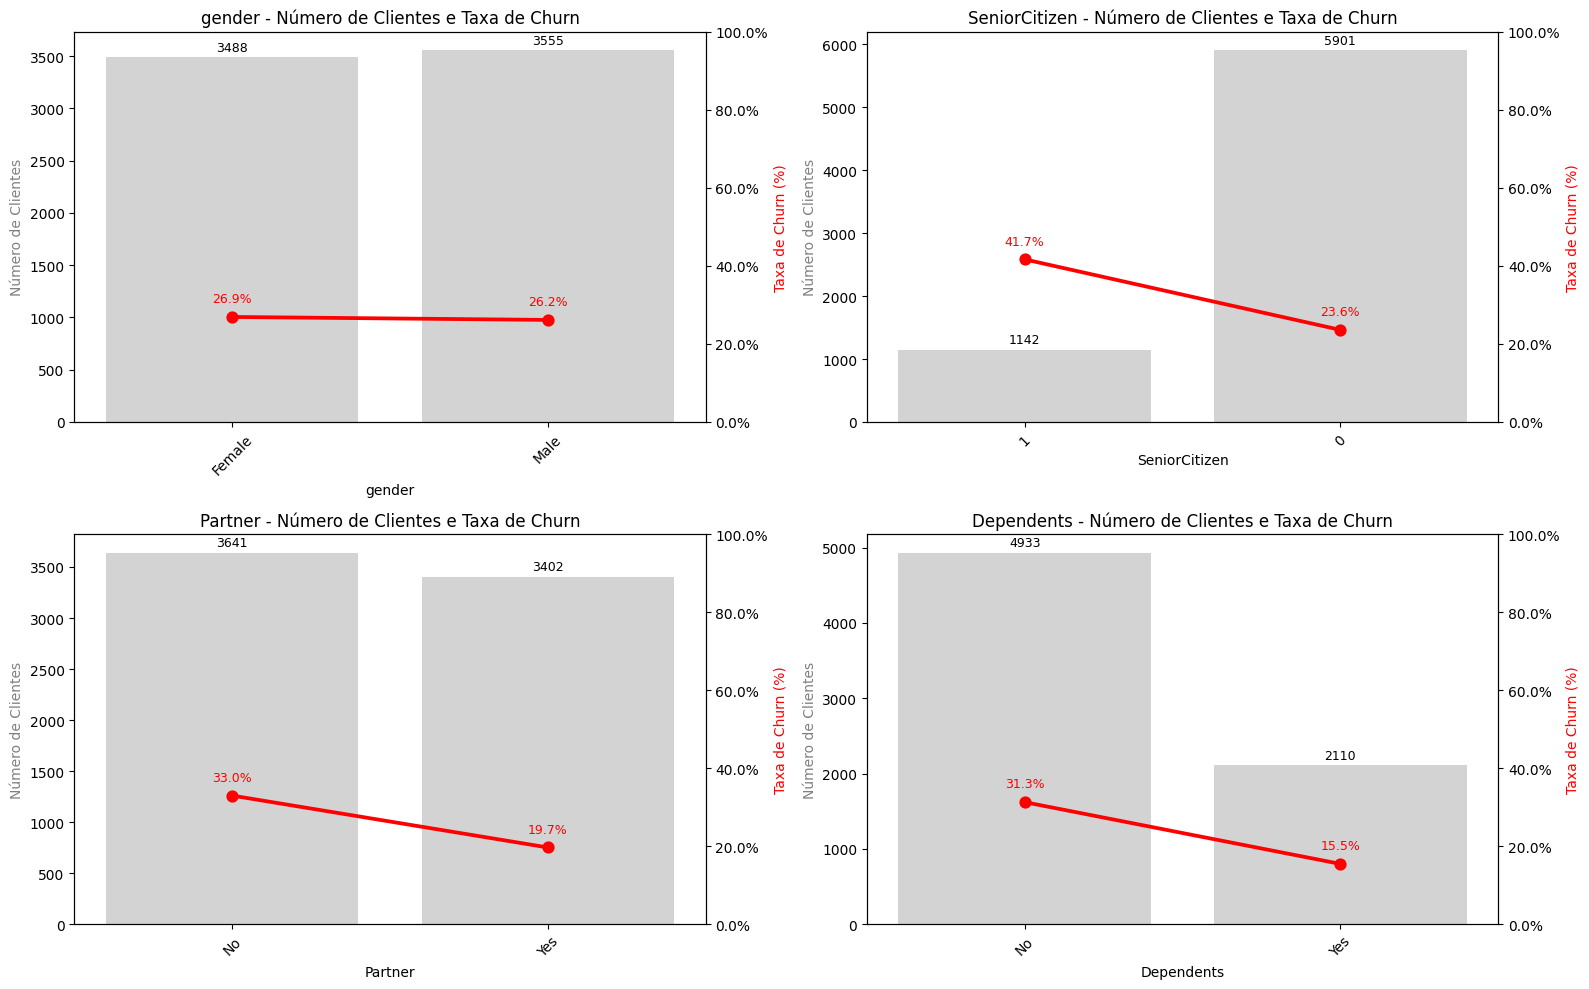

In [33]:
categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
plot_categorical_churn_with_counts(data, categorical_vars)


**Gender:**
- Não há diferença significativa na taxa de churn entre gêneros. Portanto, gender não aparenta ser um bom preditor de churn.

**SeniorCitizen**
- Clientes idosos têm **quase o dobro de probabilidade de cancelar o serviço**. `SeniorCitizen` aparenta uma forte correlação com churn e deve ser considerada em qualquer modelo.

**Partner**
- Ter um parceiro está **associado com menor churn**. Possivelmente, clientes com parceiros têm mais estabilidade ou vínculos com o serviço.

**Dependents**
- Clientes com dependentes têm **menos propensão a cancelar** o serviço, talvez por dependerem mais da estabilidade. Essa variável também pode ser importante para o modelo
    

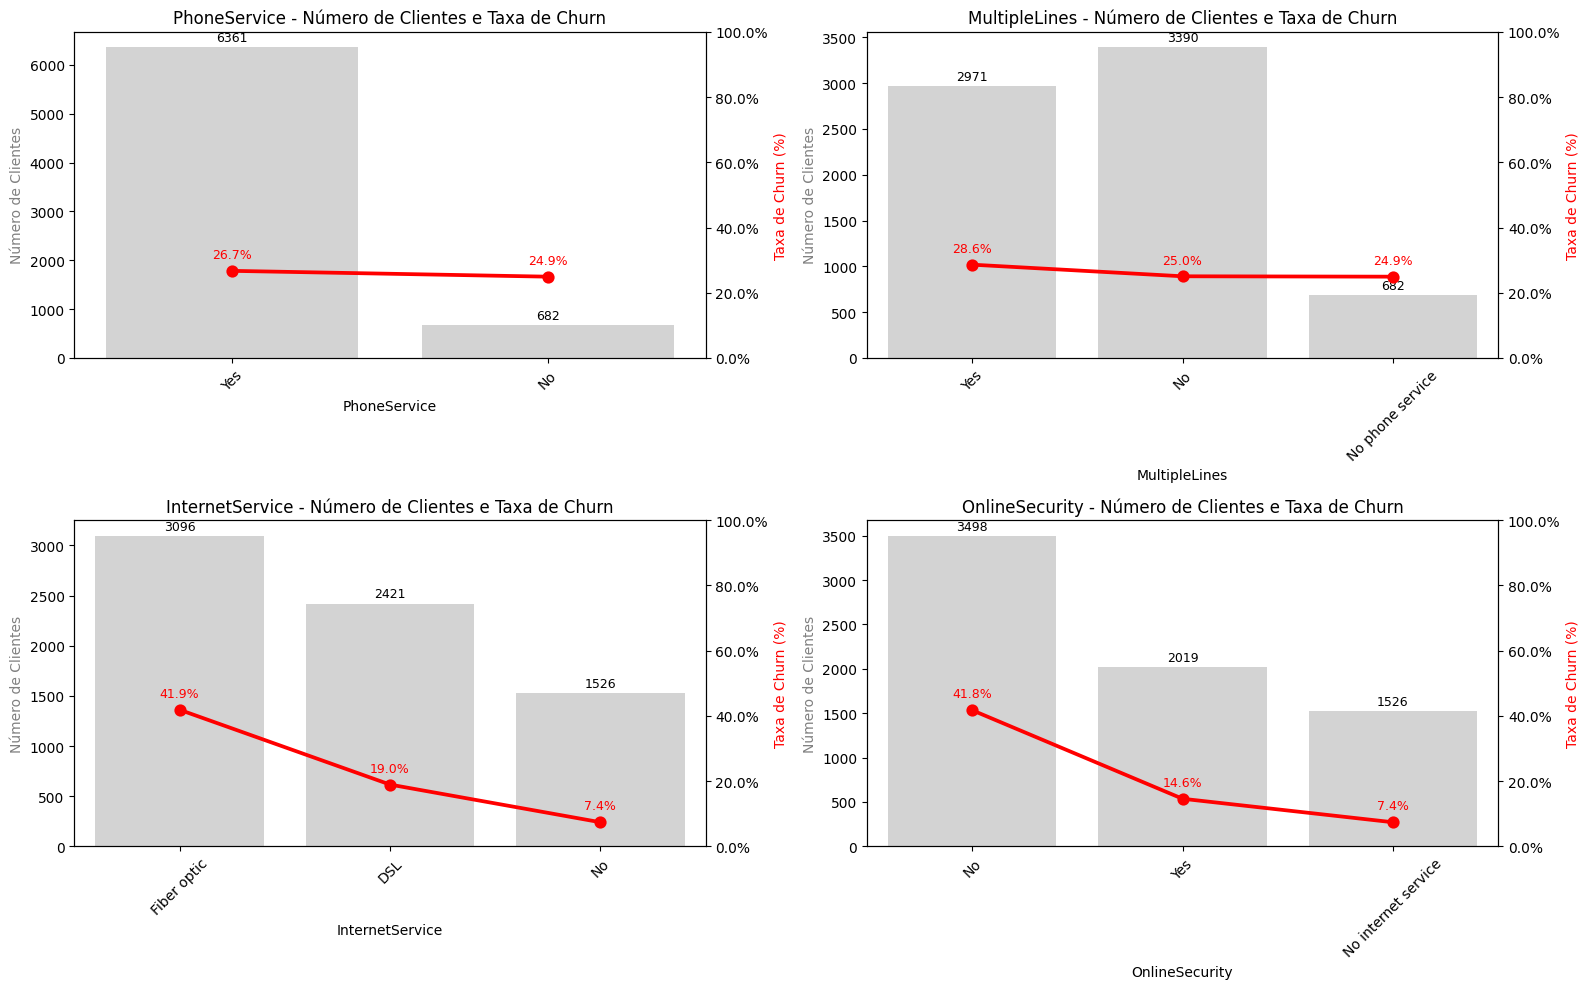

In [34]:
categorical_vars = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity']
plot_categorical_churn_with_counts(data, categorical_vars)

**PhoneService**

- A taxa de churn é **levemente maior** para quem possui serviço telefônico. Contudo, a diferença é pequena.

**MultipleLines**

- Ter múltiplas linhas está **levemente associado** a uma taxa maior de churn. Mas a diferença também não é tão expressiva.

**InternetService**

- Clientes com **fibra óptica têm altíssima taxa de churn**, muito superior aos que usam DSL. Quem **não tem internet dificilmente cancela**, o que pode ser por já não estarem engajados no serviço

**OnlineSecurity**

- Clientes **sem segurança online** têm uma taxa de churn muito maior. Isso mostra que **não contratar serviços adicionais de segurança** pode estar ligado à insatisfação.

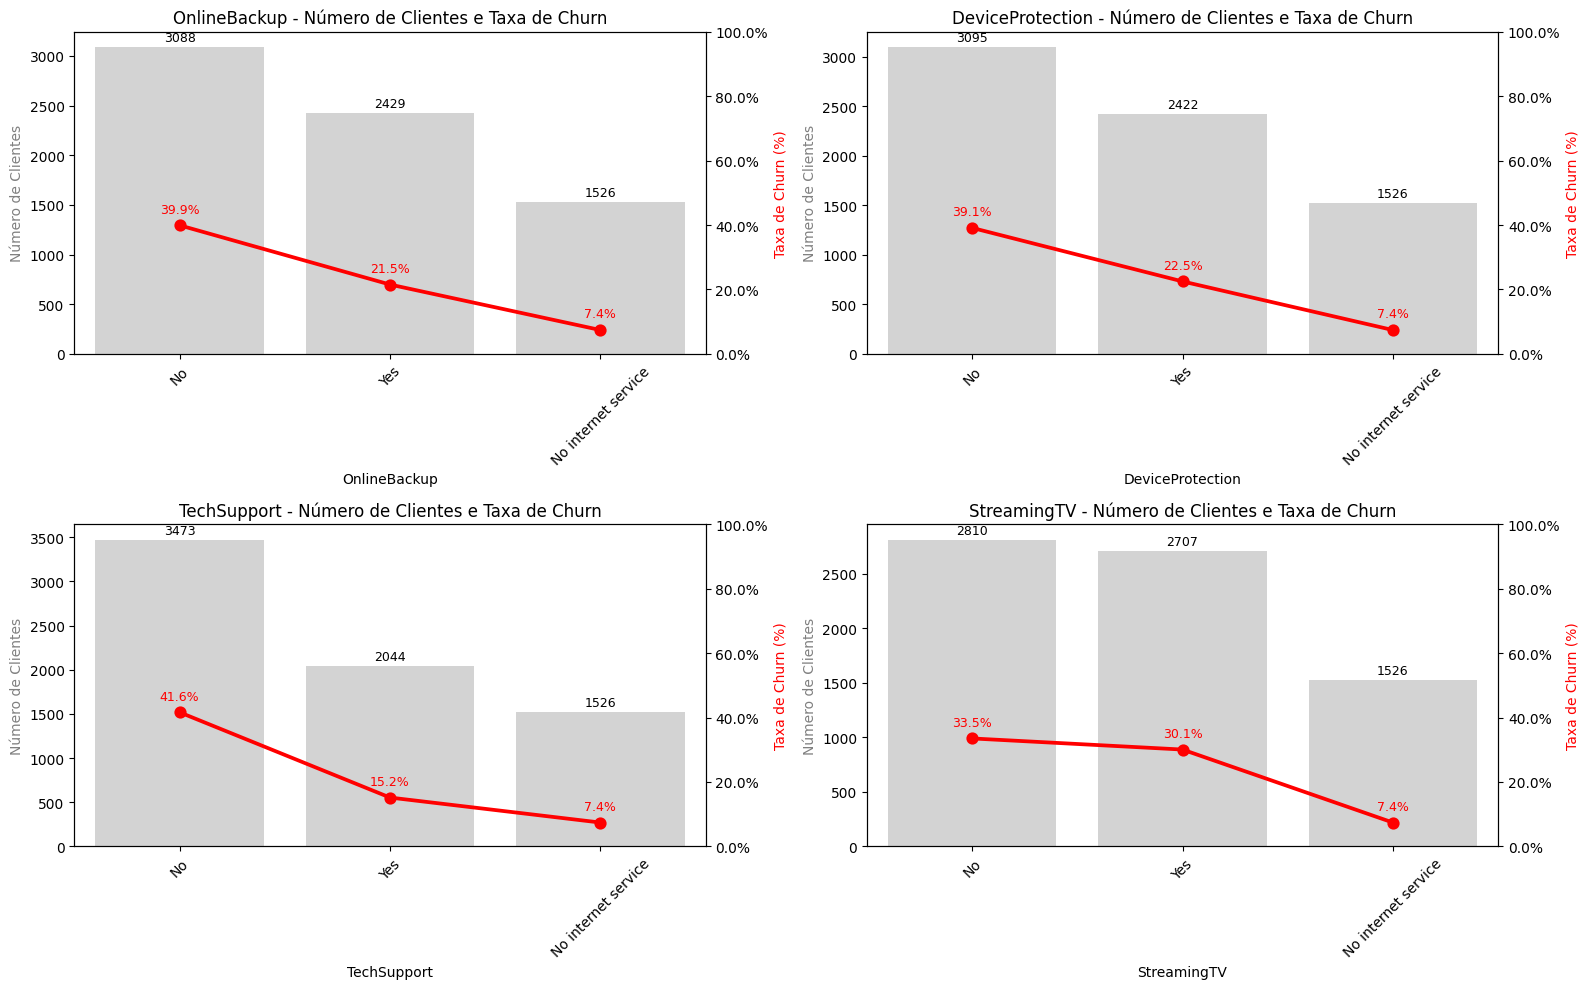

In [35]:
categorical_vars = ['OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV']
plot_categorical_churn_with_counts(data, categorical_vars)

**OnlineBackup**
- Clientes que **não têm backup online** apresentam **quase o dobro** da taxa de churn comparado aos que possuem.

**DeviceProtection**
- Mais uma vez, a **ausência de serviços adicionais** como proteção de dispositivos está relacionada a maior churn.

**TechSupport**
- Este é um dos maiores contrastes entre sim e não. Quem tem suporte técnico permanece muito mais. **Impacto muito alto** → TechSupport é um fortíssimo preditor de churn.
Estratégias que aumentem o uso ou a percepção de valor do suporte podem reduzir o churn drasticamente.

**StreamingTV**
- A diferença entre sim e não é **pequena**, mas existe. O churn é **ligeiramente maior para quem não usa StreamingTV**.

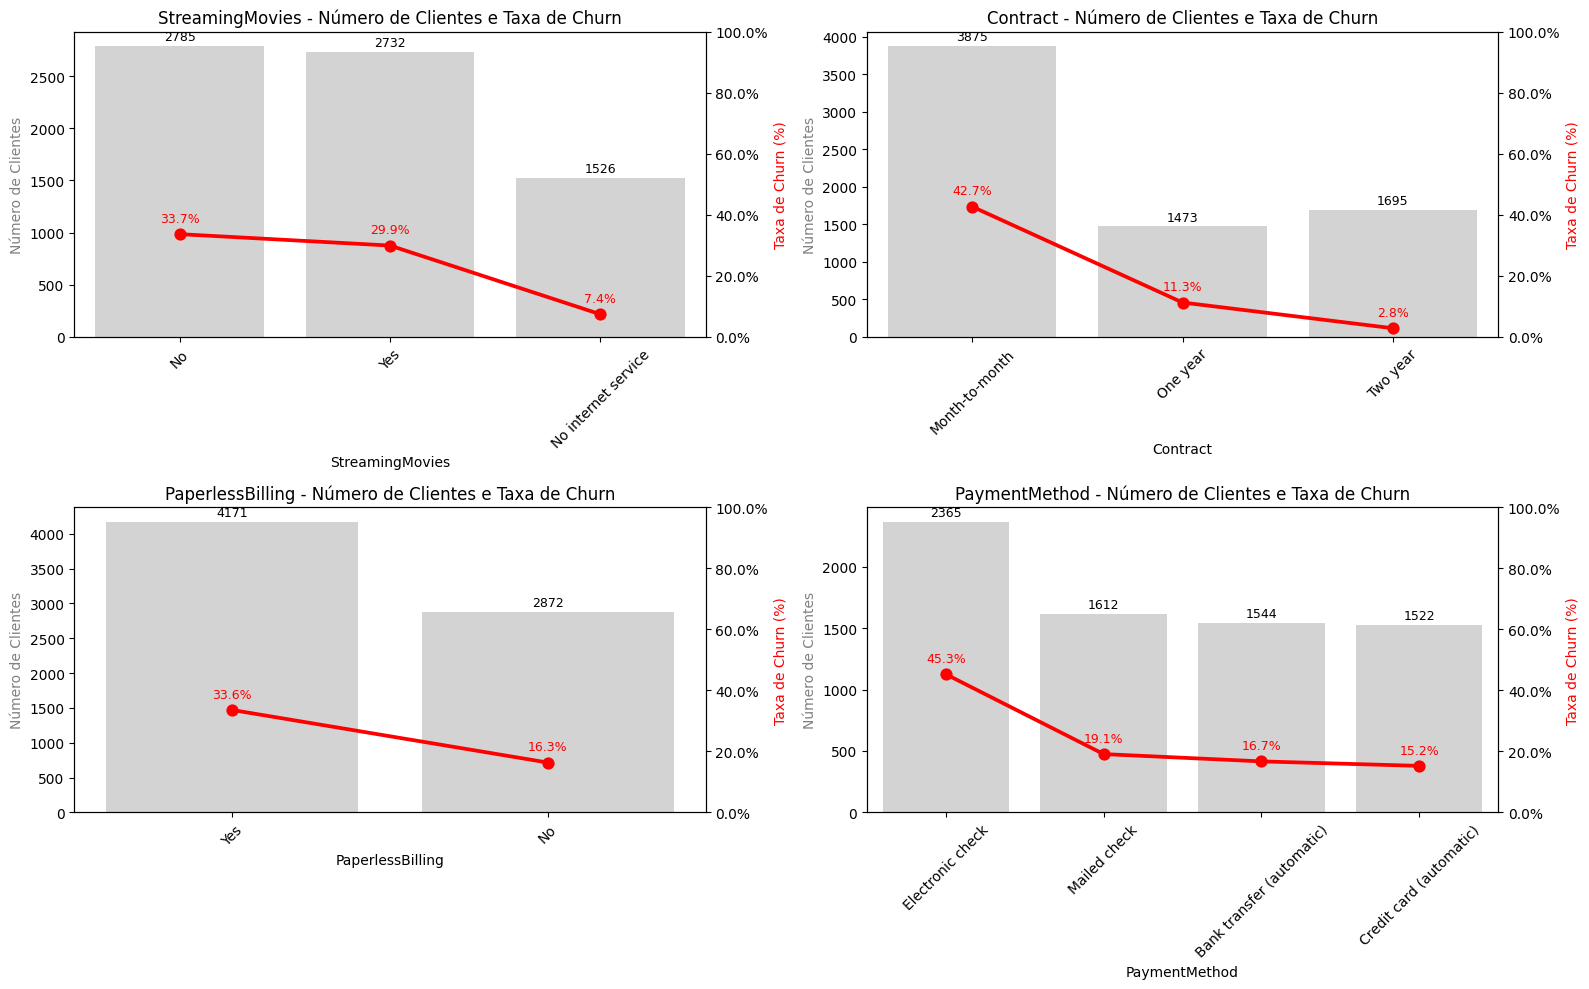

In [36]:
categorical_vars = ['StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
plot_categorical_churn_with_counts(data, categorical_vars)

**StreamingMovies**
- A diferença entre clientes que usam e não usam StreamingMovies é pequena (cerca de 4%).

**Contract**
- Clientes com contratos mais longos **churnam muito menos**.

**PaperlessBilling**
- Usuários com `PaperlessBilling` têm **o dobro da taxa de churn**. Pode indicar perfil mais digital, que troca de serviço com mais facilidade.

**PaymentMethod**
- Pagamentos automáticos (cartão e transferência) têm menor churn. `Electronic` check apresenta a **maior taxa de churn**.

### **3.2. Variáveis numéricas vs Churn**

In [37]:
def plot_numeric_vs_target(data, feature, target='Churn', figsize=(12, 6)):
    """
    Gera boxplot e violin plot para uma variável numérica específica vs variável target.
    
    Parâmetros:
        - data: DataFrame Pandas
        - feature: Nome da variável numérica a ser analisada
        - target: Nome da variável alvo (default = 'Churn')
        - figsize: Tamanho dos gráficos (default = (12, 6))
    """
    # Validação
    if feature not in data.columns:
        raise ValueError(f"A coluna '{feature}' não existe no DataFrame.")
    
    if not pd.api.types.is_numeric_dtype(data[feature]):
        raise TypeError(f"A coluna '{feature}' não é numérica.")

    plt.figure(figsize=figsize)

    # Boxplot com hue=target para evitar FutureWarning
    plt.subplot(1, 2, 1)
    sns.boxplot(x=target, y=feature, data=data, hue=target, palette="Set2", legend=False)
    plt.title(f'Boxplot: {feature} vs {target}')

    # Violin plot com hue=target para evitar FutureWarning
    plt.subplot(1, 2, 2)
    sns.violinplot(x=target, y=feature, data=data, hue=target, palette="Set2", legend=False)
    plt.title(f'Violin Plot: {feature} vs {target}')
    
    plt.tight_layout()
    plt.show()


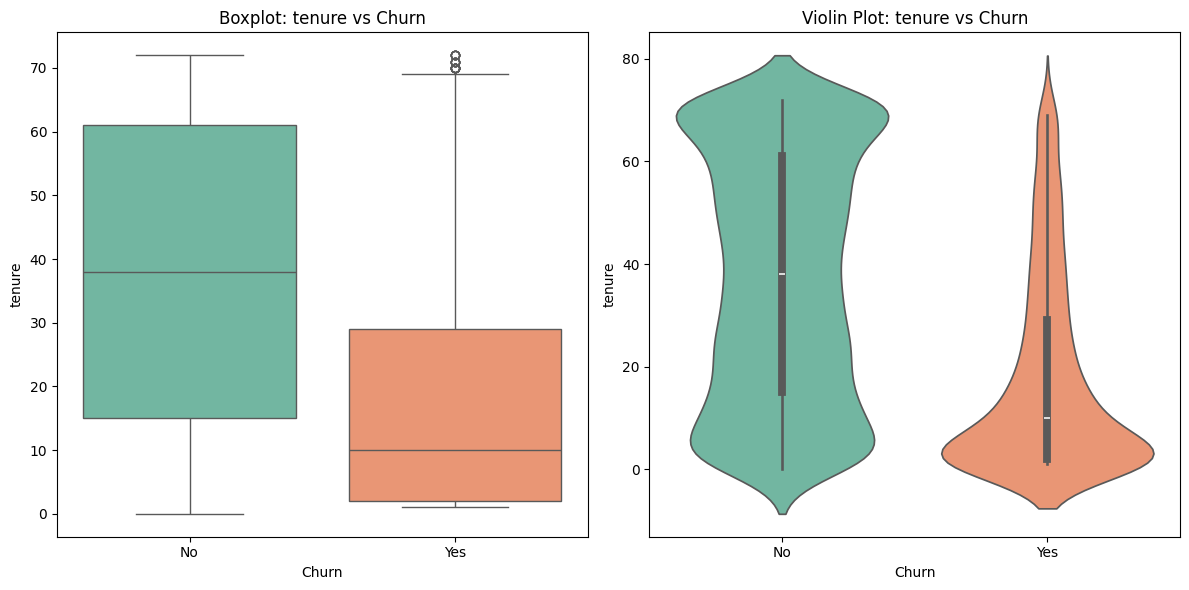

In [38]:
plot_numeric_vs_target(data, 'tenure')

**1. Clientes que NÃO saíram (`Churn = No`):**
- Têm uma distribuição de tenure muito mais ampla.

- A mediana está alta (por volta de 38 meses).

- Há muitos clientes com tempo de permanência entre 20 e 70 meses.

- Poucos outliers.

**2. Clientes que saíram (`Churn = Yes`):**
- A maioria tem tenure baixo (mediana por volta de 10 meses).

- A distribuição é concentrada nos primeiros meses de uso.

- A cauda direita mostra que alguns ficaram bastante tempo, mas são minoria.

- Há vários outliers para valores maiores de tenure.

**Conclusão**

- Clientes com **maior tempo de permanência** têm menor chance de cancelamento.

- O churn ocorre principalmente nos primeiros meses de relacionamento.

- Isso sugere que trabalhar em estratégias de retenção precoce **podem ser eficazes** para reduzir o churn.

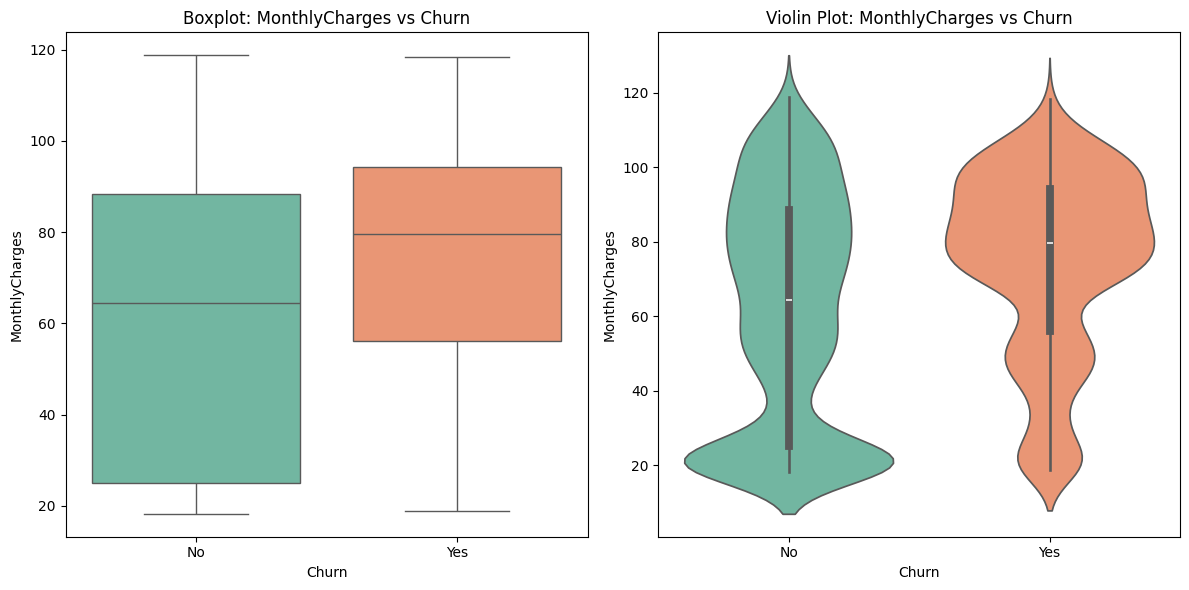

In [39]:
plot_numeric_vs_target(data, 'MonthlyCharges')

**1. Clientes que NÃO saíram (`Churn = No`):**

- Gastos mensais apresentam maior variabilidade, com muitos clientes pagando valores baixos a médios.

- A mediana está abaixo de 70.

- Distribuição mais espalhada e com alta densidade em valores baixos (como visto na parte larga inferior do violin plot).

**2. Clientes que saíram (`Churn = Yes`):**

- Os clientes que cancelaram têm uma mediana de gastos mais alta (próxima de 80).

- A densidade se concentra em valores mais altos de cobrança mensal (violin plot mais largo entre 70–100).

- Sugere que clientes com faturas mais caras tendem a cancelar com mais frequência.

**Conclusão**

- Clientes que pagam mais mensalmente têm maior propensão ao churn.

- Possivelmente, planos mais caros não estão atendendo às expectativas, ou causam insatisfação.

- Estratégias como melhor alinhamento de valor percebido com o custo ou ofertas para planos caros podem ajudar na retenção.

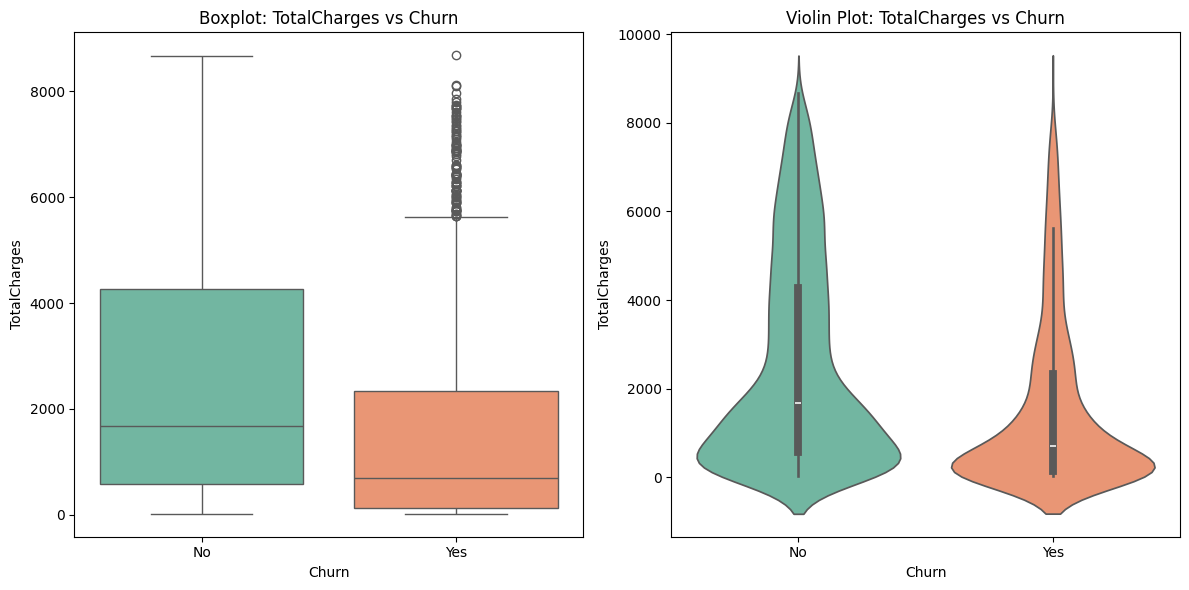

In [40]:
plot_numeric_vs_target(data, 'TotalCharges')

**1. Clientes que NÃO saíram (`Churn = No`):**

- `TotalCharges` desses clientes tende a ser mais alto comparado aos que saíram.

- A mediana dos gastos totais é significativamente maior.

- O boxplot mostra uma dispersão ampla, com vários outliers acima da mediana (clientes que gastaram muito ao longo do tempo).

- O violin plot reforça a densidade concentrada em níveis mais altos de `TotalCharges`, indicando que muitos desses clientes têm longa permanência e valores acumulados.

- Clientes fiéis tendem a acumular mais cobranças ao longo do tempo, pois continuam no serviço.

**2. Clientes que saíram (`Churn = Yes`):**

- A mediana de `TotalCharges` é bem mais baixa, mostrando que muitos cancelam nos primeiros meses.

- A distribuição é assimétrica, com concentração de densidade em valores baixos (violin plot com base larga entre 0–1000).

- O boxplot indica menos variabilidade nos valores e menos outliers extremos.

- Isso sugere que clientes que saem tendem a fazê-lo cedo — talvez por insatisfação inicial ou barreiras na adesão

**Conclusões (Insights):**

- Clientes com maiores `TotalCharges` tendem a permanecer — sinalizando maior tempo de permanência e possível satisfação com o serviço.

- Clientes que cancelam têm baixo `TotalCharges`, sugerindo problemas na experiência inicial.

- Estratégias para reduzir churn precoce são fundamentais:

- Melhor onboarding

- Suporte proativo nos primeiros meses

- Período de testes ou benefícios iniciai

## **🔗 4. Multivariate Analysis**

### **4.1. Correlação entre variáveis numéricas**

In [41]:
def analisar_correlacao(df, metodo=None, annot=True, figsize_heatmap=(10, 8), cmap='coolwarm'):
    """
    Analisa correlação entre variáveis numéricas e gera scatter plots.

    Parâmetros:
    - df: DataFrame do pandas.
    - metodo: Método de correlação ('pearson', 'spearman', 'kendall').
    - annot: Mostrar valores no heatmap.
    - figsize_heatmap: Tamanho da figura do heatmap.
    - figsize_scatters: Tamanho base da figura dos scatter plots.
    - cmap: Mapa de cores para o heatmap.

    Retorna:
    - Matriz de correlação.
    """
    # Seleciona colunas numéricas válidas (sem NaN)
    df_num = df.select_dtypes(include=['int64', 'float64']).dropna()

    if df_num.shape[1] < 2:
        print("É necessário ao menos duas variáveis numéricas.")
        return None

    # === 1. Matriz de Correlação ===
    corr_matrix = df_num.corr(method=metodo)

    plt.figure(figsize=figsize_heatmap)
    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, fmt=".2f", square=True, linewidths=0.5)
    plt.title(f'Matriz de Correlação - Método: {metodo.capitalize()}', fontsize=14)
    plt.tight_layout()
    plt.show()

    return corr_matrix


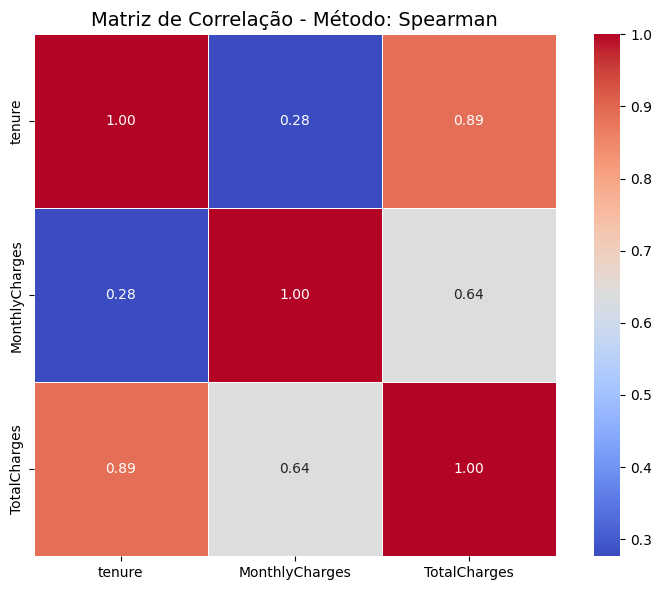

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.276417,0.886998
MonthlyCharges,0.276417,1.000000,0.637475
TotalCharges,0.886998,0.637475,1.000000


In [42]:
analisar_correlacao(data, metodo='spearman', figsize_heatmap=(8,6))


**🔹 Correlação entre tenure e TotalCharges (~0.89)**

- Isso era esperado, pois: `TotalCharges` é uma variável acumulativa — quanto maior o tempo de permanência (`tenure`), maior a cobrança total.

**🔹 Correlação entre MonthlyCharges e TotalCharges (~0.64)**

- Também é esperado, porque: `TotalCharges` ≈ `MonthlyCharges` × `tenure`, ou seja, mesmo que `MonthlyCharges` varie, ele ainda é um dos principais componentes de `TotalCharges`.

**🔹 Correlação entre tenure e MonthlyCharges (~0.28)**

- Essa relação é fraca, o que também faz sentido: O tempo que o cliente está no plano (`tenure`) não está diretamente ligado ao quanto ele paga por mês. Os planos podem ter valores mensais variados, independentemente do tempo de permanência.

### **4.2. Gráficos de pares**

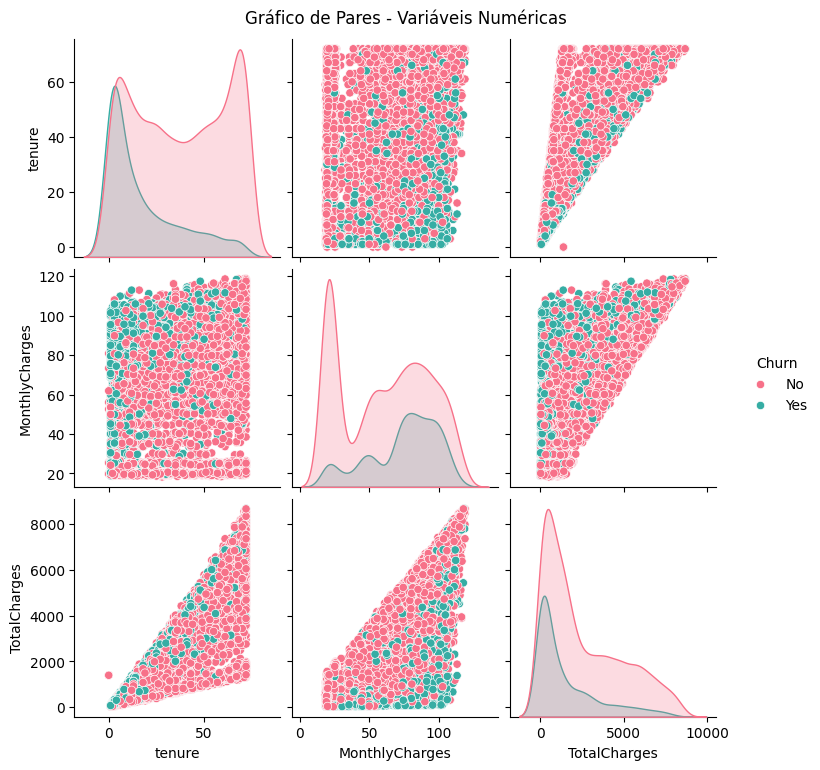

In [43]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Se seu DataFrame se chama df:
sns.pairplot(data[num_features + ['Churn']], hue='Churn', palette='husl', diag_kind='kde')
plt.suptitle('Gráfico de Pares - Variáveis Numéricas', y=1.02)
plt.show()

## **🧹 5. Preparação para Modelagem**

### **5.1. Entendendo o Impacto das Variáveis Categóricas via Codificação e Correlação**

Antes de treinar o modelo de Machine Learning, é fundamental transformar as variáveis categóricas para um formato numérico que os algoritmos consigam interpretar corretamente. Como nosso objetivo inicial é identificar as variáveis mais relevantes para prever o Churn, adotamos uma estratégia de codificação mista com dois propósitos:

1. Verificar correlações lineares entre variáveis categóricas e a variável-alvo utilizando OneHotEncoder.

2. Posteriormente, aplicar LabelEncoder em todas as variáveis categóricas para alimentar um modelo de árvore (Random Forest), que é mais sensível a relações não lineares e permite avaliar a importância de cada feature na predição.

In [44]:
# Criando uma cópia do dataset original para o pré-processamento para o treinamento do modelo. 
data_model = data.copy()

In [45]:
# Removendo a coluna de CustomerID:
data_model = data_model.drop(columns=['customerID', 'gender'])

In [46]:
data_model['AvgMonthlySpend'] = data_model['TotalCharges'] / (data_model['tenure'] + 1)

# Quantos serviços online o cliente não possui
data_model['NoOnlineServices'] = (
    (data_model['OnlineSecurity'] == 'No').astype(int) +
    (data_model['OnlineBackup'] == 'No').astype(int) +
    (data_model['DeviceProtection'] == 'No').astype(int) +
    (data_model['TechSupport'] == 'No').astype(int)
)

# Quantos serviços de entretenimento não possui
data_model['NoStreaming'] = (
    (data_model['StreamingTV'] == 'No').astype(int) +
    (data_model['StreamingMovies'] == 'No').astype(int)
)

# Total de serviços que o cliente possui
def count_services(row):
    count = 0
    service_cols = [
        'PhoneService', 'MultipleLines', 'InternetService',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    for col in service_cols:
        if 'No internet service' in row[col] or 'No phone service' in row[col]:
            continue
        if row[col] in ['Yes', 'Fiber optic', 'DSL']:
            count += 1
    return count

data_model['TotalServices'] = data_model.apply(count_services, axis=1)


# Risco de churn (heurística de score)
data_model['RiskScore'] = ((data_model['Contract'] == 'Month-to-month').astype(int) + (data_model['OnlineSecurity'] == 'No').astype(int) +
    (data_model['TechSupport'] == 'No').astype(int) + (data_model['PaymentMethod'] == 'Electronic check').astype(int) + (data_model['tenure'] < 6).astype(int))


Inicialmente aplicamos um método híbrido de transformação de variáveis, utilizando:

- **LabelEncoder** para variáveis binárias (ex: `Partner`, `Churn`, `PhoneService`), onde a codificação ordinal não distorce o significado dos dados.

- **OneHotEncoder** para variáveis com múltiplas categorias (ex: `InternetService`, `Contract`, `PaymentMethod`), garantindo que os algoritmos não assumam relações ordinais inexistentes entre as categorias.

Essa abordagem permite explorar a matriz de correlação entre as variáveis codificadas e o `Churn`. No entanto, é importante destacar que a correlação de Pearson mede apenas relações lineares, o que pode limitar a interpretação em casos mais complexos.

In [47]:
def transform_dataframe_hibryd_method(df):
    """
    Aplica LabelEncoder e OneHotEncoder conforme as colunas especificadas.
    
    Retorna um DataFrame com as colunas transformadas.
    """
    # Colunas para LabelEncoder
    label_cols = [ 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'PaperlessBilling', 'Churn']
    
    # Colunas para OneHotEncoder
    onehot_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies', 'Contract', 'PaymentMethod']
    
    df_transformed = df.copy()
    
    # Aplicando LabelEncoder
    label_encoder = LabelEncoder()
    for col in label_cols:
        df_transformed[col] = label_encoder.fit_transform(df_transformed[col])
    
    # Aplicando OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False, drop=None)
    ohe_array = ohe.fit_transform(df_transformed[onehot_cols])
    ohe_columns = ohe.get_feature_names_out(onehot_cols)
    df_ohe = pd.DataFrame(ohe_array, columns=ohe_columns, index=df.index)
    
    # Remover colunas one-hot originais e adicionar as codificadas
    df_transformed.drop(columns=onehot_cols, inplace=True)
    df_final = pd.concat([df_transformed, df_ohe], axis=1)
    
    return df_final


In [48]:
df_encoded = transform_dataframe_hibryd_method(data_model)

#Verificando as dimensões: 
df_encoded.shape

(7043, 45)

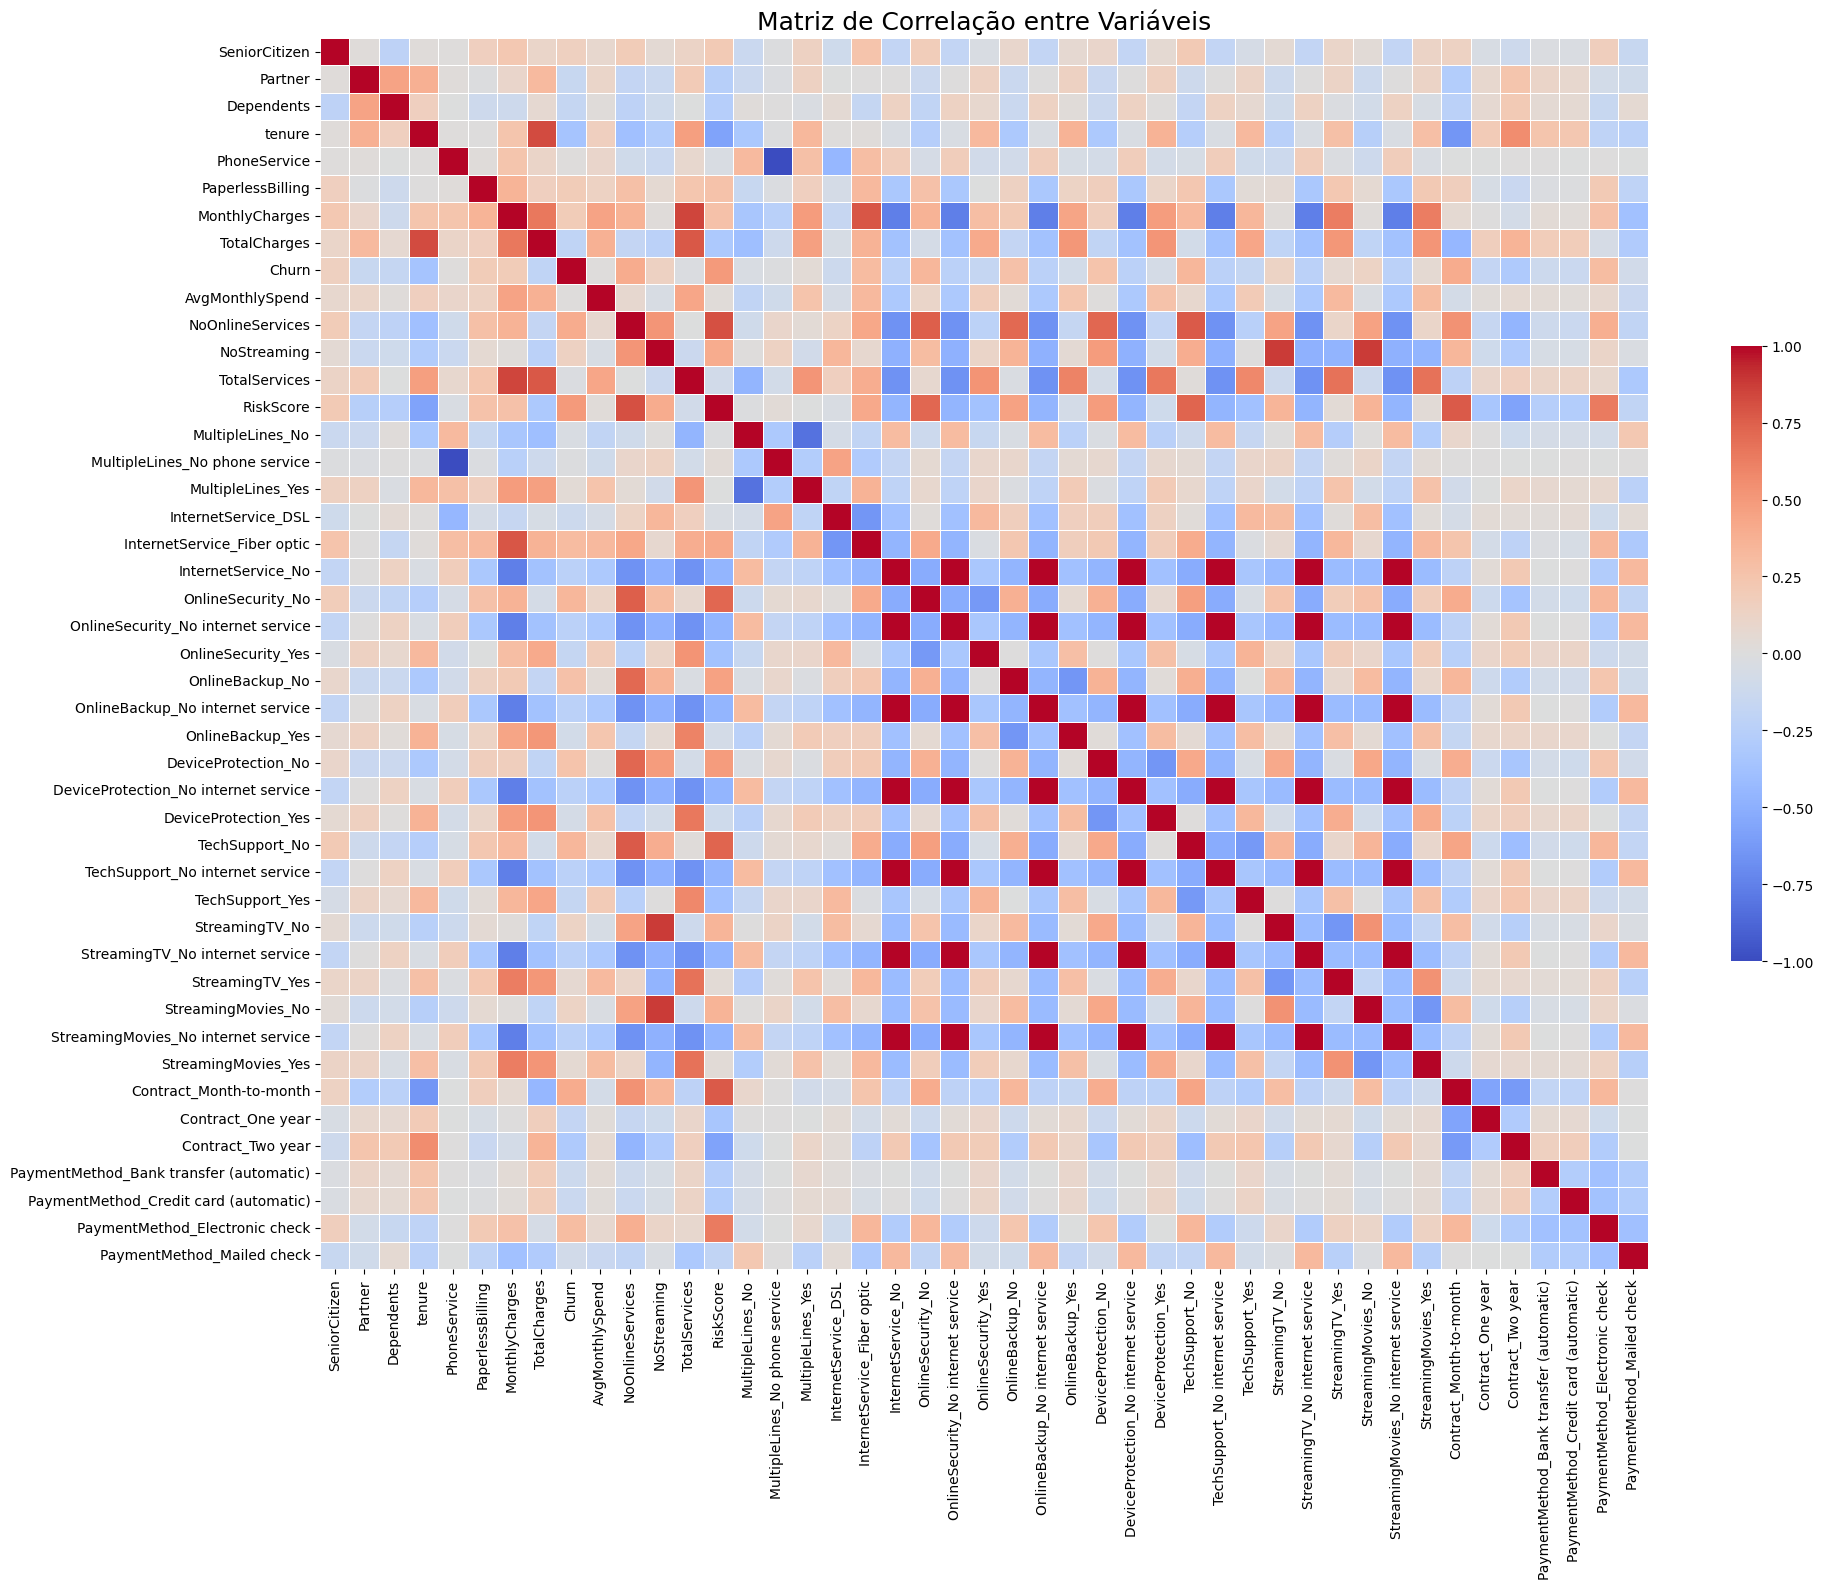

In [49]:
# Calcula a matriz de correlação
corr_matrix = df_encoded.corr()

# Define o tamanho da figura
plt.figure(figsize=(20, 16))

# Plota o heatmap
sns.heatmap(corr_matrix, 
            annot=False,  # se quiser exibir os valores, mude para True
            cmap='coolwarm', 
            center=0,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

# Título
plt.title('Matriz de Correlação entre Variáveis', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [50]:
# Calcula a correlação de todas as variáveis com a variável alvo 'Churn'
churn_corr = df_encoded.corr()['Churn'].drop('Churn').sort_values(ascending=False)

# Exibe a lista
print(churn_corr)

RiskScore                                  0.499789
NoOnlineServices                           0.405400
Contract_Month-to-month                    0.405103
OnlineSecurity_No                          0.342637
TechSupport_No                             0.337281
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
OnlineBackup_No                            0.268005
DeviceProtection_No                        0.252481
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
SeniorCitizen                              0.150889
NoStreaming                                0.148119
StreamingMovies_No                         0.130845
StreamingTV_No                             0.128916
StreamingTV_Yes                            0.063228
StreamingMovies_Yes                        0.061382
MultipleLines_Yes                          0.040102
AvgMonthlySpend                            0.014873
PhoneService

**Limitações da Análise Linear**

- Ao aplicar o OneHotEncoder e analisar a correlação entre as variáveis e o churn, observamos que:

- Poucas variáveis apresentaram correlação forte com a variável alvo.

- Isso pode indicar que existem relações não lineares mais complexas que não são capturadas pela simples análise de correlação.

Por isso, decidimos complementar a análise com um modelo baseado em árvores, que consegue capturar interações e relações não lineares entre as variáveis.

Modelos baseados em árvores, como o Random Forest, não são sensíveis à escala ou ordens artificiais criadas por LabelEncoder, e conseguem tratar adequadamente variáveis categóricas mesmo quando codificadas como inteiros. Assim, transformamos todas as variáveis categóricas com o LabelEncoder, o que:

- Evita a alta dimensionalidade causada por OneHotEncoder, especialmente quando temos muitas variáveis com múltiplas categorias.

- Permite uma análise direta da importância das features através dos critérios de divisão do modelo (Gini ou Entropia).

- Captura relações não lineares entre as variáveis e o Churn.

In [51]:
def apply_label_encoding(df):
    """
    Aplica LabelEncoder em todas as colunas categóricas (tipo 'object') do DataFrame.
    
    Parâmetros:
    df (pd.DataFrame): DataFrame de entrada
    
    Retorna:
    pd.DataFrame: DataFrame com colunas categóricas codificadas
    """
    df_encoded = df.copy()
    label_encoders = {}
    
    for col in df_encoded.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le  # Guarda o encoder, caso queira reverter depois

    return df_encoded, label_encoders

In [52]:
df_encoded, encoders = apply_label_encoding(data_model)
df_encoded.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgMonthlySpend,NoOnlineServices,NoStreaming,TotalServices,RiskScore
0,0,1,0,1,0,1,0,0,2,0,...,1,2,29.85,29.85,0,14.925000,3,2,2,5
1,0,0,0,34,1,0,0,2,0,2,...,0,3,56.95,1889.50,0,53.985714,2,2,4,1
2,0,0,0,2,1,0,0,2,2,0,...,1,3,53.85,108.15,1,36.050000,2,2,4,3
3,0,0,0,45,0,1,0,2,0,2,...,0,0,42.30,1840.75,0,40.016304,1,2,4,0
4,0,0,0,2,1,0,1,0,0,0,...,1,2,70.70,151.65,1,50.550000,4,2,2,5


In [61]:
df_encoded.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'AvgMonthlySpend', 'NoOnlineServices',
       'NoStreaming', 'TotalServices', 'RiskScore'],
      dtype='object')

              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1294
           1       0.65      0.47      0.54       467

    accuracy                           0.79      1761
   macro avg       0.74      0.69      0.70      1761
weighted avg       0.78      0.79      0.78      1761



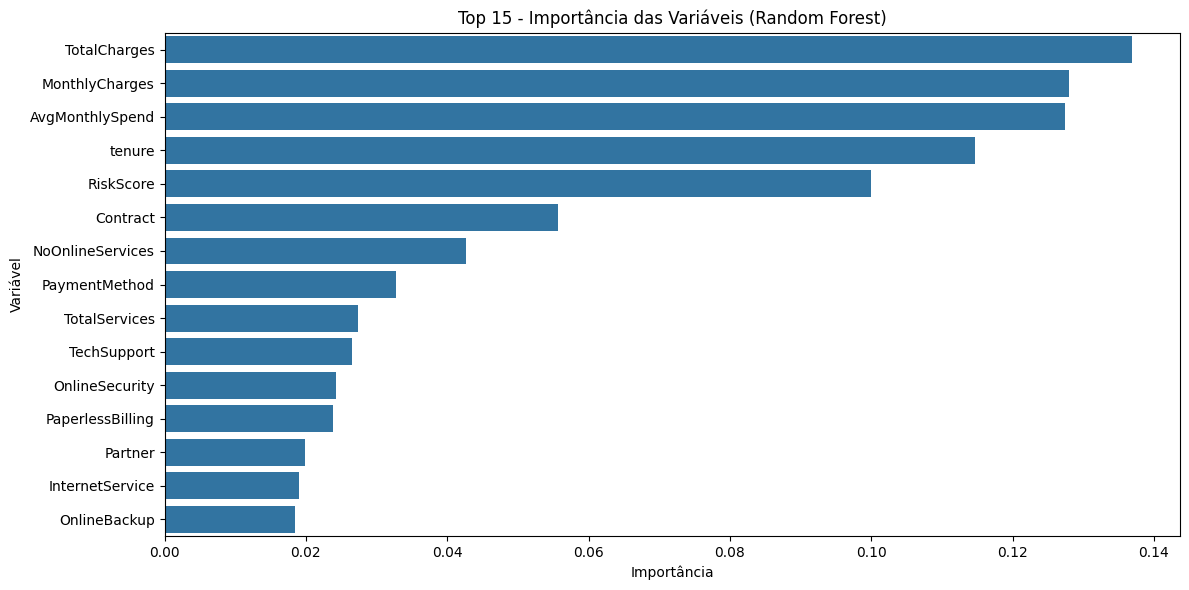

In [53]:
# 1. Preparar os dados
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# 2. Treinar modelo RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 3. Avaliar modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 4. Importância das features (Random Forest)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title("Top 15 - Importância das Variáveis (Random Forest)")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()


### **5.2. Pré-Processamento**

In [55]:
# 1. Aplicar label encoding com sua função
df_encoded, label_encoders = apply_label_encoding(data_model)

# 2. Separar features e target
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# 3. Dividir em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Aplicar SMOTE após a divisão do treino
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 5. Inicializar RandomForest com class_weight balanceado
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# 6. Definir parâmetros para GridSearch
param_grid = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    }

# 7. GridSearchCV com validação cruzada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)

# 8. Iniciar experimento MLflow e rodar o treino
with mlflow.start_run(run_name="RandomForest_SMOTE_GridSearch_4_scoring_f1", nested=True) as run:
    grid_search.fit(X_resampled, y_resampled)
    
    # 9. Previsões no conjunto de teste original
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # 10. Avaliação das métricas
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # 11. Logar parâmetros do melhor modelo
    mlflow.log_params(grid_search.best_params_)
    
    # 12. Logar métricas
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    
    # 13. Logar o modelo treinado
    mlflow.sklearn.log_model(best_model, "random_forest_model")
    
    # 14. Impressão dos resultados
    print("Melhores parâmetros encontrados:", grid_search.best_params_)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


2025/06/09 22:57:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Melhores parâmetros encontrados: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      1035
           1       0.56      0.69      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409

Confusion Matrix:
 [[829 206]
 [115 259]]


In [56]:
# 1. Aplicar label encoding com sua função
df_encoded, label_encoders = apply_label_encoding(data_model)

# 2. Separar features e target
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# 3. Dividir em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Aplicar SMOTE após a divisão do treino
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 5. Inicializar XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 6. Definir parâmetros para GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 7. GridSearchCV com validação cruzada
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)

# 8. Iniciar experimento MLflow e rodar o treino
with mlflow.start_run(run_name="XGBoost_SMOTE_GridSearch_f1", nested=True) as run:
    grid_search.fit(X_resampled, y_resampled)

    # 9. Previsões no conjunto de teste original
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # 10. Avaliação das métricas
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # 11. Logar parâmetros do melhor modelo
    mlflow.log_params(grid_search.best_params_)

    # 12. Logar métricas
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    # 13. Logar o modelo treinado
    mlflow.sklearn.log_model(best_model, "xgboost_model")

    # 14. Impressão dos resultados
    print("Melhores parâmetros encontrados:", grid_search.best_params_)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits


d:\MLOPS\MLOPS_PROJECT_TELCO_CUSTUMER_CHURCH\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:57:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/06/09 22:57:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Melhores parâmetros encontrados: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1035
           1       0.57      0.64      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.79      0.78      0.78      1409

Confusion Matrix:
 [[853 182]
 [133 241]]
